# 🧠 Deep Learning Model Experimentation

**Tujuan Notebook:**
- Eksperimen dengan berbagai arsitektur deep learning yang ringan untuk mobile
- Membandingkan performa model FastText/CBOW, LSTM, GRU, dan 1D CNN
- Menganalisis efisiensi model untuk deployment mobile
- Memilih model terbaik berdasarkan akurasi dan ukuran

**Model yang akan diuji:**
1. **FastText/CBOW** - Model embedding sederhana dengan GlobalAveragePooling
2. **LSTM** - Recurrent Neural Network untuk sequence modeling
3. **GRU** - Gated Recurrent Unit (lebih efisien dari LSTM)
4. **1D CNN** - Convolutional Neural Network untuk text classification
5. **Hybrid CNN-GRU** - Kombinasi CNN dan GRU untuk performa optimal

**Catatan:** Untuk final evaluation dan TFLite export (termasuk quantization), silakan gunakan **Notebook 04**.


### 🚦 Petunjuk Eksekusi (Run All)

- Jalankan notebook ini dari atas ke bawah tanpa melewati cell.
- Pastikan dependensi sudah terpasang sesuai `requirements.txt`.
- Preprocessing diseragamkan: Tokenizer Keras, padding/truncating 'post', MAX_LEN=256.
- Untuk deployment mobile, gunakan ekspor TFLite bawaan (builtin-only) dan tokenizer JSON.


## 📚 Import Libraries

In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Embedding, LSTM, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D,
    GlobalAveragePooling1D, Dropout, BatchNormalization, Concatenate, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Utilities
import os
import time
import json
from datetime import datetime
import pickle
import joblib
import tokenizers

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ All libraries imported successfully!")
print(f"📊 TensorFlow version: {tf.__version__}")
print(f"🐍 NumPy version: {np.__version__}")
print(f"🐼 Pandas version: {pd.__version__}")


✅ All libraries imported successfully!
📊 TensorFlow version: 2.15.0
🐍 NumPy version: 1.24.3
🐼 Pandas version: 2.1.3


## 📂 Load Preprocessed Data

In [2]:
print("="*80)
print("📂 LOADING PREPROCESSED DATA")
print("="*80)

# Configuration
DATA_DIR = 'data_splits'
MAX_LENGTH = 256
MAX_WORDS = 10000

# ============================================================================
# LOAD DATA SPLITS
# ============================================================================

print(f"\n📥 Loading data from '{DATA_DIR}'...")

try:
    # Load CSV files
    train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
    val_df = pd.read_csv(f'{DATA_DIR}/val.csv')
    test_df = pd.read_csv(f'{DATA_DIR}/test.csv')
    
    print(f"✅ Data loaded successfully!")
    print(f"   Training set: {len(train_df):,} samples")
    print(f"   Validation set: {len(val_df):,} samples")
    print(f"   Test set: {len(test_df):,} samples")
    
except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print(f"   Please ensure '{DATA_DIR}' folder contains:")
    print(f"   - train.csv")
    print(f"   - val.csv")
    print(f"   - test.csv")
    raise

# ============================================================================
# EXTRACT TEXT AND LABELS
# ============================================================================

print(f"\n📝 Extracting text and labels...")

# Extract text (use 'text' column which contains cleaned text)
X_train_text = train_df['text'].astype(str).values
X_val_text = val_df['text'].astype(str).values
X_test_text = test_df['text'].astype(str).values

# Extract labels
y_train_labels = train_df['label'].values
y_val_labels = val_df['label'].values
y_test_labels = test_df['label'].values

print(f"✅ Text and labels extracted")
print(f"   Text type: {type(X_train_text[0])}")
print(f"   Label type: {type(y_train_labels[0])}")

# Sample preview
print(f"\n📋 Sample data:")
print(f"   Train[0]: [{y_train_labels[0]:5}] {X_train_text[0][:80]}...")
print(f"   Val[0]:   [{y_val_labels[0]:5}] {X_val_text[0][:80]}...")
print(f"   Test[0]:  [{y_test_labels[0]:5}] {X_test_text[0][:80]}...")

# ============================================================================
# LOAD OR CREATE TOKENIZER
# ============================================================================

print(f"\n🔤 Loading/creating tokenizer...")

tokenizer_loaded = False

# Try to load existing tokenizer from multiple locations
tokenizer_paths = [
    f'{DATA_DIR}/tokenizer.pkl',
    'models/tokenizer.pkl',
    'tokenizer.pkl'
]

for path in tokenizer_paths:
    try:
        tokenizer = joblib.load(path)
        print(f"✅ Tokenizer loaded from: {path}")
        tokenizer_loaded = True
        break
    except FileNotFoundError:
        continue

# Create new tokenizer if not found
if not tokenizer_loaded:
    print(f"⚠️  Tokenizer not found, creating new one...")
    
    # Create tokenizer
    tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
    
    # Fit only on training data (important!)
    tokenizer.fit_on_texts(X_train_text)
    
    # Save tokenizer
    import os
    os.makedirs('models', exist_ok=True)
    joblib.dump(tokenizer, 'models/tokenizer.pkl')
    
    print(f"✅ New tokenizer created and saved to 'models/tokenizer.pkl'")

print(f"   Vocabulary size: {len(tokenizer.word_index):,}")
print(f"   Max words: {MAX_WORDS:,}")

# ============================================================================
# TOKENIZATION AND PADDING
# ============================================================================

print(f"\n🔄 Converting text to sequences...")

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train_text)
X_val_sequences = tokenizer.texts_to_sequences(X_val_text)
X_test_sequences = tokenizer.texts_to_sequences(X_test_text)

print(f"✅ Text converted to sequences")

# Pad sequences
print(f"\n📏 Padding sequences to max length {MAX_LENGTH}...")

X_train = pad_sequences(X_train_sequences, maxlen=MAX_LENGTH, 
                       padding='post', truncating='post')
X_val = pad_sequences(X_val_sequences, maxlen=MAX_LENGTH, 
                     padding='post', truncating='post')
X_test = pad_sequences(X_test_sequences, maxlen=MAX_LENGTH, 
                      padding='post', truncating='post')

print(f"✅ Sequences padded")

# ============================================================================
# ENCODE LABELS
# ============================================================================

print(f"\n🏷️  Encoding labels...")

# Try to load existing label encoder
try:
    label_encoder = joblib.load(f'{DATA_DIR}/label_encoder.pkl')
    print(f"✅ Label encoder loaded from '{DATA_DIR}/label_encoder.pkl'")
except FileNotFoundError:
    print(f"⚠️  Label encoder not found, creating new one...")
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train_labels)
    joblib.dump(label_encoder, f'{DATA_DIR}/label_encoder.pkl')
    print(f"✅ New label encoder created and saved")

# Transform labels
y_train = label_encoder.transform(y_train_labels)
y_val = label_encoder.transform(y_val_labels)
y_test = label_encoder.transform(y_test_labels)

print(f"   Classes: {list(label_encoder.classes_)}")
print(f"   Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# ============================================================================
# LOAD METADATA
# ============================================================================

print(f"\n📋 Loading metadata...")

try:
    with open(f'{DATA_DIR}/split_metadata.json', 'r', encoding='utf-8') as f:
        split_metadata = json.load(f)
    
    print(f"✅ Metadata loaded from '{DATA_DIR}/split_metadata.json'")
    
except FileNotFoundError:
    print(f"⚠️  Metadata not found, creating basic metadata...")
    split_metadata = {
        'dataset_info': {
            'total_samples': len(X_train) + len(X_val) + len(X_test)
        },
        'split_info': {
            'train_size': len(X_train),
            'val_size': len(X_val),
            'test_size': len(X_test)
        }
    }

# ============================================================================
# CREATE COMPREHENSIVE METADATA
# ============================================================================

metadata = {
    'dataset_info': {
        'total_samples': len(X_train) + len(X_val) + len(X_test),
        'num_classes': len(label_encoder.classes_),
        'label_classes': list(label_encoder.classes_),
        'label_mapping': dict(zip(label_encoder.classes_, 
                                 label_encoder.transform(label_encoder.classes_))),
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'vocab_size': len(tokenizer.word_index),
        'max_length': MAX_LENGTH,
        'max_words': MAX_WORDS,
    },
    'preprocessing': {
        'tokenizer': 'Keras Tokenizer',
        'padding': 'post',
        'truncating': 'post',
        'oov_token': '<OOV>',
    }
}

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print(f"\n{'='*80}")
print("✅ DATA LOADING COMPLETE!")
print('='*80)

print(f"""
📊 Dataset Summary:
   Total samples: {metadata['dataset_info']['total_samples']:,}
   
   Training:   {len(X_train):,} samples
   Validation: {len(X_val):,} samples
   Test:       {len(X_test):,} samples

📐 Data Shapes:
   X_train:  {X_train.shape}
   y_train:  {y_train.shape}
   X_val:    {X_val.shape}
   y_val:    {y_val.shape}
   X_test:   {X_test.shape}
   y_test:   {y_test.shape}

🔤 Tokenization Info:
   Vocabulary size: {len(tokenizer.word_index):,}
   Max words: {MAX_WORDS:,}
   Sequence length: {MAX_LENGTH}
   Padding: post
   Truncating: post

🏷️  Label Info:
   Classes: {list(label_encoder.classes_)}
   Mapping: {metadata['dataset_info']['label_mapping']}
   
   Training distribution:
   - {label_encoder.classes_[0]}: {sum(y_train == 0):,} ({sum(y_train == 0)/len(y_train)*100:.1f}%)
   - {label_encoder.classes_[1]}: {sum(y_train == 1):,} ({sum(y_train == 1)/len(y_train)*100:.1f}%)

✅ Variables ready for training:
   - X_train, y_train: Training data
   - X_val, y_val: Validation data
   - X_test, y_test: Test data
   - tokenizer: For preprocessing new text
   - label_encoder: For label encoding/decoding
   - metadata: Complete dataset information

🚀 Ready for model training!

Example usage:
   model.fit(X_train, y_train, 
            validation_data=(X_val, y_val),
            epochs=10, 
            batch_size=32)
""")

# ============================================================================
# SAVE PROCESSED DATA (OPTIONAL)
# ============================================================================

save_processed = False  # Set to True if you want to save

if save_processed:
    print(f"\n💾 Saving processed data...")
    
    import os
    os.makedirs('processed_data', exist_ok=True)
    
    # Save as numpy arrays
    np.save('processed_data/X_train.npy', X_train)
    np.save('processed_data/X_val.npy', X_val)
    np.save('processed_data/X_test.npy', X_test)
    np.save('processed_data/y_train.npy', y_train)
    np.save('processed_data/y_val.npy', y_val)
    np.save('processed_data/y_test.npy', y_test)
    
    # Save metadata
    with open('processed_data/metadata.json', 'w', encoding='utf-8') as f:
        json.dump(metadata, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Processed data saved to 'processed_data/' folder")

print(f"\n{'='*80}")
print("🎯 All data loaded and ready for training!")
print('='*80)

📂 LOADING PREPROCESSED DATA

📥 Loading data from 'data_splits'...
✅ Data loaded successfully!
   Training set: 86,408 samples
   Validation set: 12,344 samples
   Test set: 24,688 samples

📝 Extracting text and labels...
✅ Text and labels extracted
   Text type: <class 'str'>
   Label type: <class 'str'>

📋 Sample data:
   Train[0]: [halal] bawang putih merica hitam garam gula merah bawang bombay red bell peppers peters...
   Val[0]:   [haram] sugar water soy sauce spices garlic corn starch tamarind paste honey salt worces...
   Test[0]:  [halal] mentega krim garam liquid telur semisweet coklat unsweetened coklat gula anhydro...

🔤 Loading/creating tokenizer...
✅ Tokenizer loaded from: models/tokenizer.pkl
   Vocabulary size: 10,544
   Max words: 10,000

🔄 Converting text to sequences...
✅ Text converted to sequences

📏 Padding sequences to max length 256...
✅ Sequences padded

🏷️  Encoding labels...
✅ Label encoder loaded from 'data_splits/label_encoder.pkl'
   Classes: ['halal', 'har

In [24]:
# convert tokenizer.pkl to tokenizer.json
import pickle
import json
import os

print("🔄 CONVERTING TOKENIZER.PKL TO TOKENIZER.JSON")
print("=" * 80)

# ============================================================================
# LOAD TOKENIZER
# ============================================================================

print("\n📂 Loading tokenizer.pkl...")

try:
    with open('models/tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
    print("✅ Tokenizer loaded successfully")
except FileNotFoundError:
    print("❌ Error: tokenizer.pkl not found!")
    print("   Please make sure tokenizer.pkl exists in the current directory")
    raise
except Exception as e:
    print(f"❌ Error loading tokenizer: {e}")
    raise

# ============================================================================
# EXTRACT TOKENIZER INFO
# ============================================================================

print("\n📊 Extracting tokenizer information...")

# Get word index
word_index = tokenizer.word_index
vocab_size = len(word_index)

# Create index to word mapping
index_word = {idx: word for word, idx in word_index.items()}

# Get tokenizer config
try:
    tokenizer_config = tokenizer.get_config()
except:
    tokenizer_config = {}

# Extract important parameters
num_words = tokenizer.num_words if hasattr(tokenizer, 'num_words') else vocab_size
oov_token = tokenizer.oov_token if hasattr(tokenizer, 'oov_token') else None
filters = tokenizer.filters if hasattr(tokenizer, 'filters') else '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
lower = tokenizer.lower if hasattr(tokenizer, 'lower') else True
split = tokenizer.split if hasattr(tokenizer, 'split') else ' '
char_level = tokenizer.char_level if hasattr(tokenizer, 'char_level') else False

print(f"   Vocabulary Size: {vocab_size:,}")
print(f"   Num Words: {num_words}")
print(f"   OOV Token: {oov_token}")
print(f"   Lowercase: {lower}")

# ============================================================================
# CREATE MOBILE-FRIENDLY JSON STRUCTURE
# ============================================================================

print("\n🔧 Creating mobile-friendly JSON structure...")

# Structure yang mudah diparse di mobile
tokenizer_json = {
    "config": {
        "vocab_size": vocab_size,
        "num_words": num_words,
        "oov_token": oov_token,
        "filters": filters,
        "lower": lower,
        "split": split,
        "char_level": char_level,
        "max_sequence_length": 256  # Sesuaikan dengan MAX_LENGTH Anda
    },
    "word_index": word_index,
    "index_word": index_word,
    "metadata": {
        "type": "Keras Tokenizer",
        "version": "1.0",
        "created_for": "Halal/Haram Food Classification",
        "languages": ["English", "Indonesian"],
        "description": "Bilingual tokenizer for food ingredient classification"
    }
}

print("✅ JSON structure created")

# ============================================================================
# SAVE FULL VERSION
# ============================================================================

print("\n💾 Saving tokenizer files...")

os.makedirs('models', exist_ok=True)

# 1. Full version (with all mappings)
full_json_path = 'models/tokenizer_full.json'
with open(full_json_path, 'w', encoding='utf-8') as f:
    json.dump(tokenizer_json, f, ensure_ascii=False, indent=2)

print(f"✅ Saved: {full_json_path}")
print(f"   Size: {os.path.getsize(full_json_path) / 1024:.2f} KB")

# ============================================================================
# CREATE COMPACT VERSION (Mobile Optimized)
# ============================================================================

print("\n📱 Creating compact version for mobile...")

# Compact version: only essential data
compact_json = {
    "config": tokenizer_json["config"],
    "word_index": word_index,  # Only word->index mapping needed for encoding
    "metadata": {
        "type": "Compact Tokenizer",
        "version": "1.0",
        "optimized_for": "Mobile Apps"
    }
}

compact_json_path = 'models/tokenizer.json'
with open(compact_json_path, 'w', encoding='utf-8') as f:
    json.dump(compact_json, f, ensure_ascii=False, indent=2)

print(f"✅ Saved: {compact_json_path}")
print(f"   Size: {os.path.getsize(compact_json_path) / 1024:.2f} KB")

🔄 CONVERTING TOKENIZER.PKL TO TOKENIZER.JSON

📂 Loading tokenizer.pkl...
✅ Tokenizer loaded successfully

📊 Extracting tokenizer information...
   Vocabulary Size: 10,544
   Num Words: 10000
   OOV Token: <OOV>
   Lowercase: True

🔧 Creating mobile-friendly JSON structure...
✅ JSON structure created

💾 Saving tokenizer files...
✅ Saved: models/tokenizer_full.json
   Size: 494.45 KB

📱 Creating compact version for mobile...
✅ Saved: models/tokenizer.json
   Size: 237.03 KB


## ⚙️ Model Configuration

In [ ]:
# Model parameters - Versi yang Disederhanakan
print("🔧 Setting up Model Configuration...")

# Try different embedding dimensions
EMBEDDING_OPTIONS = {
    'fast': 64,      # Fast training, good baseline
    'balanced': 128, # RECOMMENDED - Best balance ⭐
    'accurate': 256, # Maximum accuracy, slower
}

# Select embedding dimension
EMBEDDING_MODE = 'balanced'  # Change to 'fast' or 'accurate' to experiment
EMBEDDING_DIM = EMBEDDING_OPTIONS[EMBEDDING_MODE]

# Other parameters
VOCAB_SIZE = 10000
MAX_LENGTH = 256
BATCH_SIZE = 32
EPOCHS = 10
PATIENCE = 3

# Coba ambil nilai dari tokenizer jika ada
try:
    if 'tokenizer' in locals() and hasattr(tokenizer, 'word_index'):
        VOCAB_SIZE = len(tokenizer.word_index) + 1
        print(f"✅ Menggunakan vocab size dari tokenizer: {VOCAB_SIZE:,}")
    else:
        print(f"⚠️ Tokenizer belum dimuat, menggunakan default vocab size: {VOCAB_SIZE:,}")
except:
    print(f"⚠️ Error saat mengakses tokenizer, menggunakan default vocab size: {VOCAB_SIZE:,}")

# Coba ambil nilai dari X_train jika ada
try:
    if 'X_train' in locals() and hasattr(X_train, 'shape') and len(X_train.shape) >= 2:
        MAX_LENGTH = X_train.shape[1]
        print(f"✅ Menggunakan max length dari data: {MAX_LENGTH}")
    else:
        print(f"⚠️ Data belum dimuat atau tidak valid, menggunakan default max length: {MAX_LENGTH}")
except:
    print(f"⚠️ Error saat mengakses X_train, menggunakan default max length: {MAX_LENGTH}")

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('logs', exist_ok=True)

# Tampilkan konfigurasi final
print(f"\n🔧 Final Model Configuration:")
print(f"   📝 Vocabulary Size: {VOCAB_SIZE:,}")
print(f"   📏 Max Sequence Length: {MAX_LENGTH}")
print(f"   🎯 Embedding Dimension: {EMBEDDING_DIM}")
print(f"   📦 Batch Size: {BATCH_SIZE}")
print(f"   🔄 Max Epochs: {EPOCHS}")
print(f"   ⏱️ Early Stopping Patience: {PATIENCE}")

# Estimate model size
embedding_params = VOCAB_SIZE * EMBEDDING_DIM
print(f"   📊 Estimated embedding layer parameters: {embedding_params:,}")
print(f"   Memory: ~{embedding_params * 4 / 1024 / 1024:.1f} MB")

# Status check yang lebih sederhana
print(f"\n📊 Data Status:")
if 'tokenizer' in locals():
    try:
        vocab_size = len(tokenizer.word_index)
        print(f"   ✅ Tokenizer: Ready (actual vocab: {vocab_size:,})")
    except:
        print(f"   ⚠️ Tokenizer: Loaded but may have issues")
else:
    print(f"   ⚠️ Tokenizer: Not loaded yet")

if 'X_train' in locals():
    try:
        print(f"   ✅ Training data: Ready {X_train.shape}")
    except:
        print(f"   ⚠️ Training data: Loaded but shape unknown")
else:
    print(f"   ⚠️ Training data: Not loaded yet")

🔧 Setting up Model Configuration...
✅ Menggunakan vocab size dari tokenizer: 10,545
✅ Menggunakan max length dari data: 256

🔧 Final Model Configuration:
   📝 Vocabulary Size: 10,545
   📏 Max Sequence Length: 256
   🎯 Embedding Dimension: 128
   📦 Batch Size: 32
   🔄 Max Epochs: 10
   ⏱️ Early Stopping Patience: 3
   📊 Estimated embedding layer parameters: 1,349,760
   Memory: ~5.1 MB

📊 Data Status:
   ✅ Tokenizer: Ready (actual vocab: 10,544)
   ✅ Training data: Ready (86408, 256)

💡 Tip: Jalankan cell 'Load Preprocessed Data' terlebih dahulu untuk hasil optimal!


## 🏗️ Model Architectures

### 1. FastText/CBOW Model

In [4]:
def build_fasttext_model(name='FastText_Model'):
    inputs = tf.keras.Input(shape=(MAX_LENGTH,), dtype='int32')
    x = tf.keras.layers.Embedding(MAX_WORDS, 128)(inputs)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

# Create and display model
fasttext_model = build_fasttext_model()
print("🚀 FastText Model Architecture:")
fasttext_model.summary()


🚀 FastText Model Architecture:
Model: "FastText_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 128)          1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                    

### 2. LSTM Model

In [5]:
def build_lstm_model(name='LSTM_Model'):
    inputs = tf.keras.Input(shape=(MAX_LENGTH,), dtype='int32')
    x = tf.keras.layers.Embedding(MAX_WORDS, 128)(inputs)
    x = tf.keras.layers.LSTM(64, dropout=0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

# Create and display model
lstm_model = build_lstm_model()
print("🔄 LSTM Model Architecture:")
lstm_model.summary()

🔄 LSTM Model Architecture:
Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 256, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1333633 (5.09 M

### 3. GRU Model

In [6]:
def build_gru_model(name='GRU_Model'):
    inputs = tf.keras.Input(shape=(MAX_LENGTH,), dtype='int32')
    x = tf.keras.layers.Embedding(MAX_WORDS, 128)(inputs)
    x = tf.keras.layers.GRU(64, dropout=0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)    

# Create and display model
gru_model = build_gru_model()   
print("⚡ GRU Model Architecture:")
gru_model.summary()

⚡ GRU Model Architecture:
Model: "GRU_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 256, 128)          1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1321473 (5.04 MB)

### 4. 1D CNN Model

In [7]:
def build_cnn1d_model(name='CNN1D_Model'):
    inputs = tf.keras.Input(name='cnn-1d', shape=(MAX_LENGTH,), dtype='int32')  
    x = tf.keras.layers.Embedding(MAX_WORDS, 128)(inputs)
    x = tf.keras.layers.Conv1D(128, 5, activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

# Create and display model
cnn1d_model = build_cnn1d_model()
print("🔍 1D CNN Model Architecture:")
cnn1d_model.summary()

🔍 1D CNN Model Architecture:
Model: "CNN1D_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn-1d (InputLayer)         [(None, 256)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 256, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 252, 128)          82048     
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                          

### 5. Hybrid CNN-GRU Model

In [8]:
def build_hybrid_cnn_gru_model(name='Hybrid_CNN_GRU_Model'):
    """
    Hybrid CNN-GRU model
    Kombinasi CNN untuk feature extraction dan GRU untuk sequence modeling
    """
    inputs = tf.keras.Input(shape=(MAX_LENGTH,), dtype='int32', name='input')  
    x = tf.keras.layers.Embedding(MAX_WORDS, 128, name='embedding')(inputs)
    
    # CNN feature extraction
    x = tf.keras.layers.Conv1D(64, 3, activation='relu', name='conv1d_1')(x)
    x = tf.keras.layers.MaxPooling1D(2, name='maxpool')(x)
    x = tf.keras.layers.Conv1D(32, 3, activation='relu', name='conv1d_2')(x)
    
    # GRU sequence modeling
    x = tf.keras.layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, name='gru')(x)
    
    # Dense layers
    x = tf.keras.layers.Dense(32, activation='relu', name='dense_1')(x)
    x = tf.keras.layers.Dropout(0.3, name='dropout')(x)
    
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and display model
hybrid_model = build_hybrid_cnn_gru_model()
print("🔥 Hybrid CNN-GRU Model Architecture:")
hybrid_model.summary()


🔥 Hybrid CNN-GRU Model Architecture:
Model: "Hybrid_CNN_GRU_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 128)          1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 254, 64)           24640     
                                                                 
 maxpool (MaxPooling1D)      (None, 127, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 125, 32)           6176      
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_1

In [9]:
# Train and evaluate
models = {
    'FastText': build_fasttext_model(),
    'CNN-1D': build_cnn1d_model(),
    'LSTM': build_lstm_model(),
    'GRU': build_gru_model(),
    'Hybrid CNN-GRU': build_hybrid_cnn_gru_model()
}

results = {}
training_histories = {}

## 🏃‍♂️ Training and Evaluation

In [10]:
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score
)
import numpy as np
import time
import os

# Dictionary untuk menyimpan hasil
training_histories = {}
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name} Model")
    print('='*60)
    
    # Compile model dengan metrics yang benar
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
            # F1Score dihitung manual nanti
        ]
    )
    
    # Setup callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
    
    # Training dengan validation set (BUKAN test set!)
    start_time = time.time()
    history = model.fit(
        X_train, y_train, 
        validation_data=(X_val, y_val),  # ✅ PERBAIKAN: Gunakan val, bukan test
        epochs=10, 
        batch_size=32, 
        callbacks=[early_stopping],
        verbose=1
    )
    train_time = time.time() - start_time
    
    # Store training history
    training_histories[name] = history.history
    
    # ============================================================
    # EVALUATION PADA TEST SET (Hanya sekali!)
    # ============================================================
    
    print(f"\n📊 Evaluating {name} on TEST set...")
    
    # Get predictions
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Calculate metrics using sklearn (lebih reliable)
    test_accuracy = np.mean(y_pred_classes == y_test)
    test_precision = precision_score(y_test, y_pred_classes)
    test_recall = recall_score(y_test, y_pred_classes)
    test_f1 = f1_score(y_test, y_pred_classes)
    test_auc = roc_auc_score(y_test, y_pred_prob)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    tn, fp, fn, tp = cm.ravel()
    
    # Critical metrics untuk halal/haram
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    # Classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(
        y_test, 
        y_pred_classes, 
        target_names=['halal', 'haram'],
        digits=4
    ))
    
    # Confusion Matrix
    print(f"\n📊 Confusion Matrix:")
    print(f"              Predicted")
    print(f"           Halal  Haram")
    print(f"Actual Halal  {tn:5d}  {fp:5d}")
    print(f"       Haram  {fn:5d}  {tp:5d}")
    print(f"\n⚠️  False Negatives (CRITICAL): {fn} ({false_negative_rate:.2%})")
    
    # ============================================================
    # CONVERT TO TFLITE
    # ============================================================
    
    print(f"\n🔄 Converting to TFLite...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    converter._experimental_lower_tensor_list_ops = False
    
    try:
        tflite_model = converter.convert()
        
        # Test inference time
        interpreter = tf.lite.Interpreter(model_content=tflite_model)
        interpreter.allocate_tensors()
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        # Warm up
        test_sample = X_test[0:1].astype(np.int32)
        interpreter.set_tensor(input_details[0]['index'], test_sample)
        interpreter.invoke()
        
        # Measure inference time
        start_time = time.time()
        for _ in range(100):
            interpreter.set_tensor(input_details[0]['index'], test_sample)
            interpreter.invoke()
        inference_time = (time.time() - start_time) / 100 * 1000
        
        model_size_kb = len(tflite_model) / 1024
        
    except Exception as e:
        print(f"⚠️  TFLite conversion failed: {e}")
        tflite_model = None
        inference_time = None
        model_size_kb = None
    
    # ============================================================
    # STORE RESULTS
    # ============================================================
    
    results[name] = {
        # Test metrics
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1,
        'auc': test_auc,
        
        # Confusion matrix metrics
        'true_negative': int(tn),
        'false_positive': int(fp),
        'false_negative': int(fn),
        'true_positive': int(tp),
        'specificity': specificity,
        'false_negative_rate': false_negative_rate,
        
        # Model info
        'train_time_sec': train_time,
        'model_size_kb': model_size_kb,
        'inference_time_ms': inference_time,
        'total_params': model.count_params(),
        'epochs_trained': len(history.history['loss']),
        
        # Best validation metrics
        'best_val_accuracy': max(history.history['val_accuracy']),
        'best_val_loss': min(history.history['val_loss']),
    }
    
    # ============================================================
    # SAVE MODELS
    # ============================================================
    
    os.makedirs('models', exist_ok=True)
    
    # Save Keras model
    model.save(f'models/{name.lower().replace("-", "_")}_model.h5')
    
    # Save TFLite model
    if tflite_model is not None:
        with open(f'models/{name.lower().replace("-", "_")}_model.tflite', 'wb') as f:
            f.write(tflite_model)
    
    # ============================================================
    # PRINT SUMMARY
    # ============================================================
    
    print(f"\n{'='*60}")
    print(f"✅ {name} Training Complete!")
    print('='*60)
    print(f"📊 Test Metrics:")
    print(f"   Accuracy:  {test_accuracy:.4f}")
    print(f"   Precision: {test_precision:.4f}")
    print(f"   Recall:    {test_recall:.4f}")
    print(f"   F1-Score:  {test_f1:.4f}")
    print(f"   AUC:       {test_auc:.4f}")
    print(f"\n⚠️  Critical Metrics:")
    print(f"   False Negative Rate: {false_negative_rate:.2%} (target: <5%)")
    print(f"   Specificity:         {specificity:.2%}")
    print(f"\n💾 Model Info:")
    print(f"   Parameters:   {model.count_params():,}")
    print(f"   Training time: {train_time:.1f}s")
    if model_size_kb:
        print(f"   Model size:   {model_size_kb:.1f} KB")
    if inference_time:
        print(f"   Inference:    {inference_time:.2f} ms")
    
    # Warning jika FNR terlalu tinggi
    if false_negative_rate > 0.05:
        print(f"\n⚠️  WARNING: False Negative Rate tinggi!")
        print(f"   {fn} produk HARAM diprediksi sebagai HALAL!")
        print(f"   Pertimbangkan tuning threshold atau model architecture.")


Training FastText Model

Epoch 1/10


2701/2701 [==============================] - 22s 8ms/step - loss: 0.2574 - accuracy: 0.8933 - precision: 0.9280 - recall: 0.8280 - auc: 0.9593 - val_loss: 0.1236 - val_accuracy: 0.9601 - val_precision: 0.9539 - val_recall: 0.9580 - val_auc: 0.9909
Epoch 2/10
2701/2701 [==============================] - 19s 7ms/step - loss: 0.0999 - accuracy: 0.9664 - precision: 0.9754 - recall: 0.9496 - auc: 0.9922 - val_loss: 0.1207 - val_accuracy: 0.9591 - val_precision: 0.9915 - val_recall: 0.9173 - val_auc: 0.9936
Epoch 3/10
2701/2701 [==============================] - 20s 8ms/step - loss: 0.0783 - accuracy: 0.9725 - precision: 0.9789 - recall: 0.9599 - auc: 0.9954 - val_loss: 0.0927 - val_accuracy: 0.9661 - val_precision: 0.9896 - val_recall: 0.9349 - val_auc: 0.9949
Epoch 4/10
2701/2701 [==============================] - 22s 8ms/step - loss: 0.0668 - accuracy: 0.9761 - precision: 0.9810 - recall: 0.9657 - auc: 0.9966 - val_loss: 0.0752 - val_accuracy: 0.9712

INFO:tensorflow:Assets written to: C:\Users\MUHAMM~1\AppData\Local\Temp\tmpifceon6r\assets



✅ FastText Training Complete!
📊 Test Metrics:
   Accuracy:  0.9792
   Precision: 0.9737
   Recall:    0.9804
   F1-Score:  0.9770
   AUC:       0.9984

⚠️  Critical Metrics:
   False Negative Rate: 1.96% (target: <5%)
   Specificity:         97.82%

💾 Model Info:
   Parameters:   1,288,321
   Training time: 207.8s
   Model size:   1261.2 KB
   Inference:    0.05 ms

Training CNN-1D Model
Epoch 1/10
2701/2701 [==============================] - 63s 23ms/step - loss: 0.1371 - accuracy: 0.9496 - precision: 0.9601 - recall: 0.9270 - auc: 0.9867 - val_loss: 0.0803 - val_accuracy: 0.9733 - val_precision: 0.9706 - val_recall: 0.9704 - val_auc: 0.9956
Epoch 2/10
2701/2701 [==============================] - 103s 38ms/step - loss: 0.0621 - accuracy: 0.9793 - precision: 0.9792 - recall: 0.9749 - auc: 0.9967 - val_loss: 0.0652 - val_accuracy: 0.9785 - val_precision: 0.9850 - val_recall: 0.9670 - val_auc: 0.9970
Epoch 3/10
2701/2701 [==============================] - 89s 33ms/step - loss: 0.0439 - 

INFO:tensorflow:Assets written to: C:\Users\MUHAMM~1\AppData\Local\Temp\tmpa44ci963\assets


INFO:tensorflow:Assets written to: C:\Users\MUHAMM~1\AppData\Local\Temp\tmpa44ci963\assets



✅ CNN-1D Training Complete!
📊 Test Metrics:
   Accuracy:  0.9879
   Precision: 0.9833
   Recall:    0.9900
   F1-Score:  0.9867
   AUC:       0.9992

⚠️  Critical Metrics:
   False Negative Rate: 1.00% (target: <5%)
   Specificity:         98.62%

💾 Model Info:
   Parameters:   1,370,369
   Training time: 508.9s
   Model size:   1344.4 KB
   Inference:    4.28 ms

Training LSTM Model
Epoch 1/10
2701/2701 [==============================] - 293s 107ms/step - loss: 0.6905 - accuracy: 0.5486 - precision: 0.5075 - recall: 0.0078 - auc: 0.4996 - val_loss: 0.6868 - val_accuracy: 0.5509 - val_precision: 1.0000 - val_recall: 0.0054 - val_auc: 0.5032
Epoch 2/10
2701/2701 [==============================] - 287s 106ms/step - loss: 0.6447 - accuracy: 0.5972 - precision: 0.7747 - recall: 0.1522 - auc: 0.6055 - val_loss: 0.2866 - val_accuracy: 0.8808 - val_precision: 0.9810 - val_recall: 0.7506 - val_auc: 0.9343
Epoch 3/10
2701/2701 [==============================] - 284s 105ms/step - loss: 0.1477 -

INFO:tensorflow:Assets written to: C:\Users\MUHAMM~1\AppData\Local\Temp\tmp8lx5mgbo\assets



✅ LSTM Training Complete!
📊 Test Metrics:
   Accuracy:  0.9897
   Precision: 0.9925
   Recall:    0.9846
   F1-Score:  0.9885
   AUC:       0.9982

⚠️  Critical Metrics:
   False Negative Rate: 1.54% (target: <5%)
   Specificity:         99.39%

💾 Model Info:
   Parameters:   1,333,633
   Training time: 1970.7s
   Model size:   1315.4 KB
   Inference:    4.36 ms

Training GRU Model
Epoch 1/10
2701/2701 [==============================] - 127s 47ms/step - loss: 0.6907 - accuracy: 0.5505 - precision: 0.5670 - recall: 0.0186 - auc: 0.5060 - val_loss: 0.6853 - val_accuracy: 0.5530 - val_precision: 1.0000 - val_recall: 0.0100 - val_auc: 0.5040
Epoch 2/10
2701/2701 [==============================] - 125s 46ms/step - loss: 0.1581 - accuracy: 0.9326 - precision: 0.9740 - recall: 0.8740 - auc: 0.9821 - val_loss: 0.0845 - val_accuracy: 0.9740 - val_precision: 0.9838 - val_recall: 0.9582 - val_auc: 0.9941
Epoch 3/10
2701/2701 [==============================] - 150s 55ms/step - loss: 0.0554 - accu

INFO:tensorflow:Assets written to: C:\Users\MUHAMM~1\AppData\Local\Temp\tmpy9czbyq4\assets



✅ GRU Training Complete!
📊 Test Metrics:
   Accuracy:  0.9936
   Precision: 0.9919
   Recall:    0.9940
   F1-Score:  0.9930
   AUC:       0.9994

⚠️  Critical Metrics:
   False Negative Rate: 0.60% (target: <5%)
   Specificity:         99.34%

💾 Model Info:
   Parameters:   1,321,473
   Training time: 1623.0s
   Model size:   1304.5 KB
   Inference:    11.70 ms

Training Hybrid CNN-GRU Model
Epoch 1/10
2701/2701 [==============================] - 269s 97ms/step - loss: 0.3784 - accuracy: 0.7776 - precision: 0.9528 - recall: 0.5338 - auc: 0.8775 - val_loss: 0.0820 - val_accuracy: 0.9723 - val_precision: 0.9843 - val_recall: 0.9539 - val_auc: 0.9936
Epoch 2/10
2701/2701 [==============================] - 262s 97ms/step - loss: 0.0624 - accuracy: 0.9785 - precision: 0.9832 - recall: 0.9688 - auc: 0.9960 - val_loss: 0.0663 - val_accuracy: 0.9777 - val_precision: 0.9911 - val_recall: 0.9593 - val_auc: 0.9960
Epoch 3/10
2701/2701 [==============================] - 263s 97ms/step - loss: 0.

INFO:tensorflow:Assets written to: C:\Users\MUHAMM~1\AppData\Local\Temp\tmpdn5a8q1_\assets



✅ Hybrid CNN-GRU Training Complete!
📊 Test Metrics:
   Accuracy:  0.9922
   Precision: 0.9900
   Recall:    0.9927
   F1-Score:  0.9914
   AUC:       0.9992

⚠️  Critical Metrics:
   False Negative Rate: 0.73% (target: <5%)
   Specificity:         99.17%

💾 Model Info:
   Parameters:   1,318,241
   Training time: 1874.1s
   Model size:   1306.6 KB
   Inference:    3.63 ms


In [11]:
# ============================================================
# SUMMARY COMPARISON
# ============================================================

import pandas as pd

print("\n" + "="*80)
print("📊 MODEL COMPARISON SUMMARY")
print("="*80)

# ----------------------------------------------------------------
# Create comparison DataFrame
# ----------------------------------------------------------------
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

# Sort by F1 score (atau metric lain yang diprioritaskan)
comparison_df = comparison_df.sort_values('f1_score', ascending=False)

# ----------------------------------------------------------------
# Display metrics
# ----------------------------------------------------------------
print("\n🏆 Ranking by F1-Score:")
print(comparison_df[['accuracy', 'precision', 'recall', 'f1_score', 'auc']].to_string())

print("\n⚠️  False Negative Rate (Lower is Better):")
print(comparison_df[['false_negative_rate', 'false_negative']].to_string())

print("\n⚡ Performance Metrics:")
print(comparison_df[['train_time_sec', 'model_size_kb', 'inference_time_ms', 'total_params']].to_string())

# ----------------------------------------------------------------
# Save results
# ----------------------------------------------------------------
results_df = pd.DataFrame(results).T
results_df.to_csv('models/comparison_results.csv')
print("\n💾 Results saved to 'models/comparison_results.csv'")

# ----------------------------------------------------------------
# Best model recommendation
# ----------------------------------------------------------------
best_f1_model = comparison_df['f1_score'].idxmax()
best_recall_model = comparison_df['recall'].idxmax()
fastest_model = comparison_df['inference_time_ms'].idxmin()

print("\n🎯 Recommendations:")
print(f"   Best F1-Score       : {best_f1_model}")
print(f"   Best Recall (Safety): {best_recall_model}")
print(f"   Fastest Inference   : {fastest_model}")

print("\n" + "="*80)
print("✅ All models trained and evaluated!")
print("="*80)


📊 MODEL COMPARISON SUMMARY

🏆 Ranking by F1-Score:
                accuracy  precision  recall  f1_score     auc
GRU               0.9936     0.9919  0.9940    0.9930  0.9994
Hybrid CNN-GRU    0.9922     0.9900  0.9927    0.9914  0.9992
LSTM              0.9897     0.9925  0.9846    0.9885  0.9982
CNN-1D            0.9879     0.9833  0.9900    0.9867  0.9992
FastText          0.9792     0.9737  0.9804    0.9770  0.9984

⚠️  False Negative Rate (Lower is Better):
                false_negative_rate  false_negative
GRU                          0.0060            67.0
Hybrid CNN-GRU               0.0073            81.0
LSTM                         0.0154           172.0
CNN-1D                       0.0100           111.0
FastText                     0.0196           219.0

⚡ Performance Metrics:
                train_time_sec  model_size_kb  inference_time_ms  total_params
GRU                  1622.9751      1304.5234            11.7009     1321473.0
Hybrid CNN-GRU       1874.0802      13

## 📊 Results Analysis & Comparison

### 📈 Visualization

📊 CREATING COMPREHENSIVE VISUALIZATION DASHBOARD

📈 Section 1: Training History Analysis...


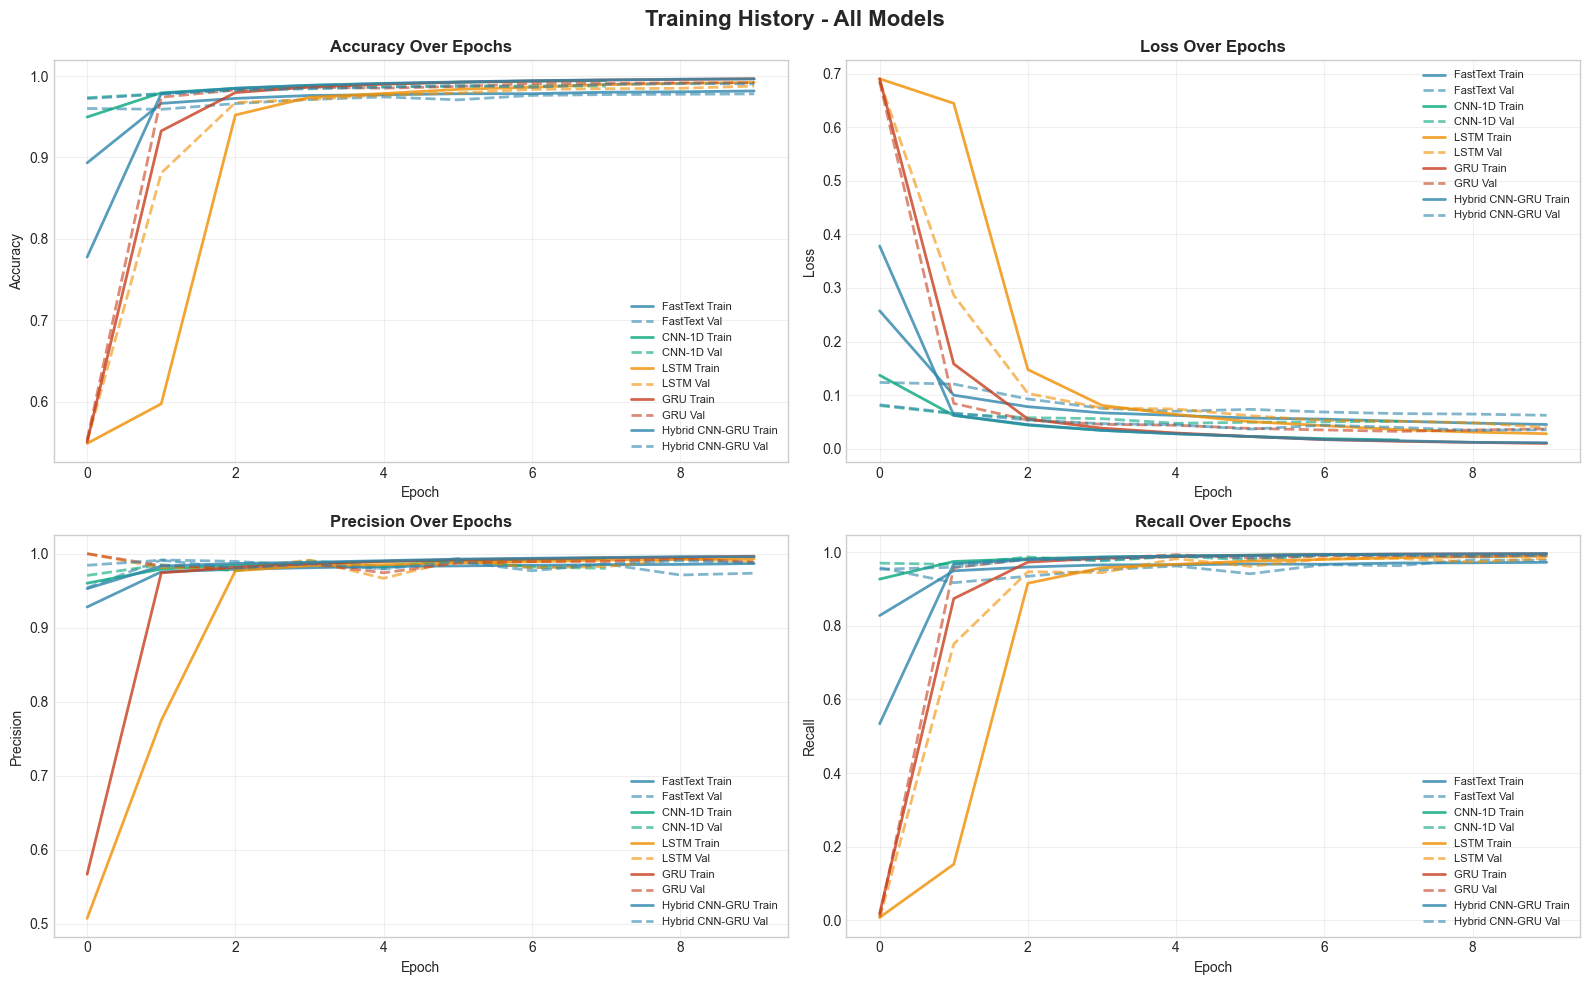

✅ Training history plots created!

📊 Section 2: Model Comparison Dashboard...


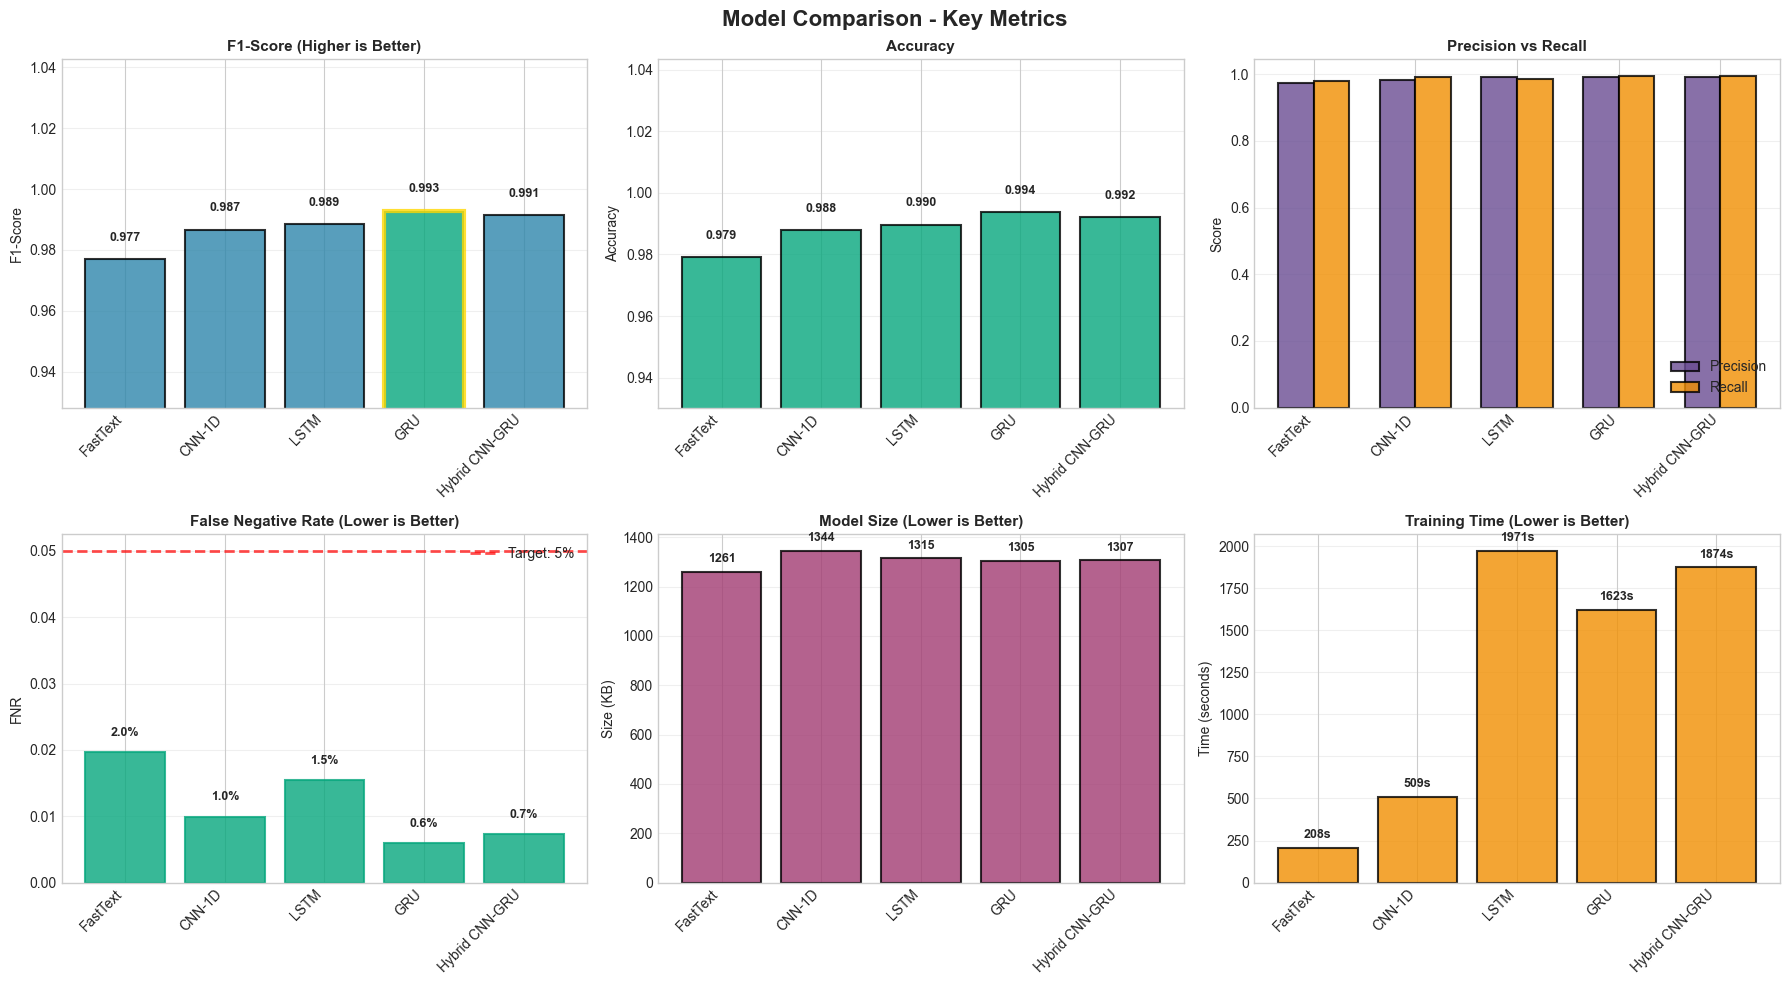

✅ Model comparison dashboard created!

🔍 Section 3: Confusion Matrices...


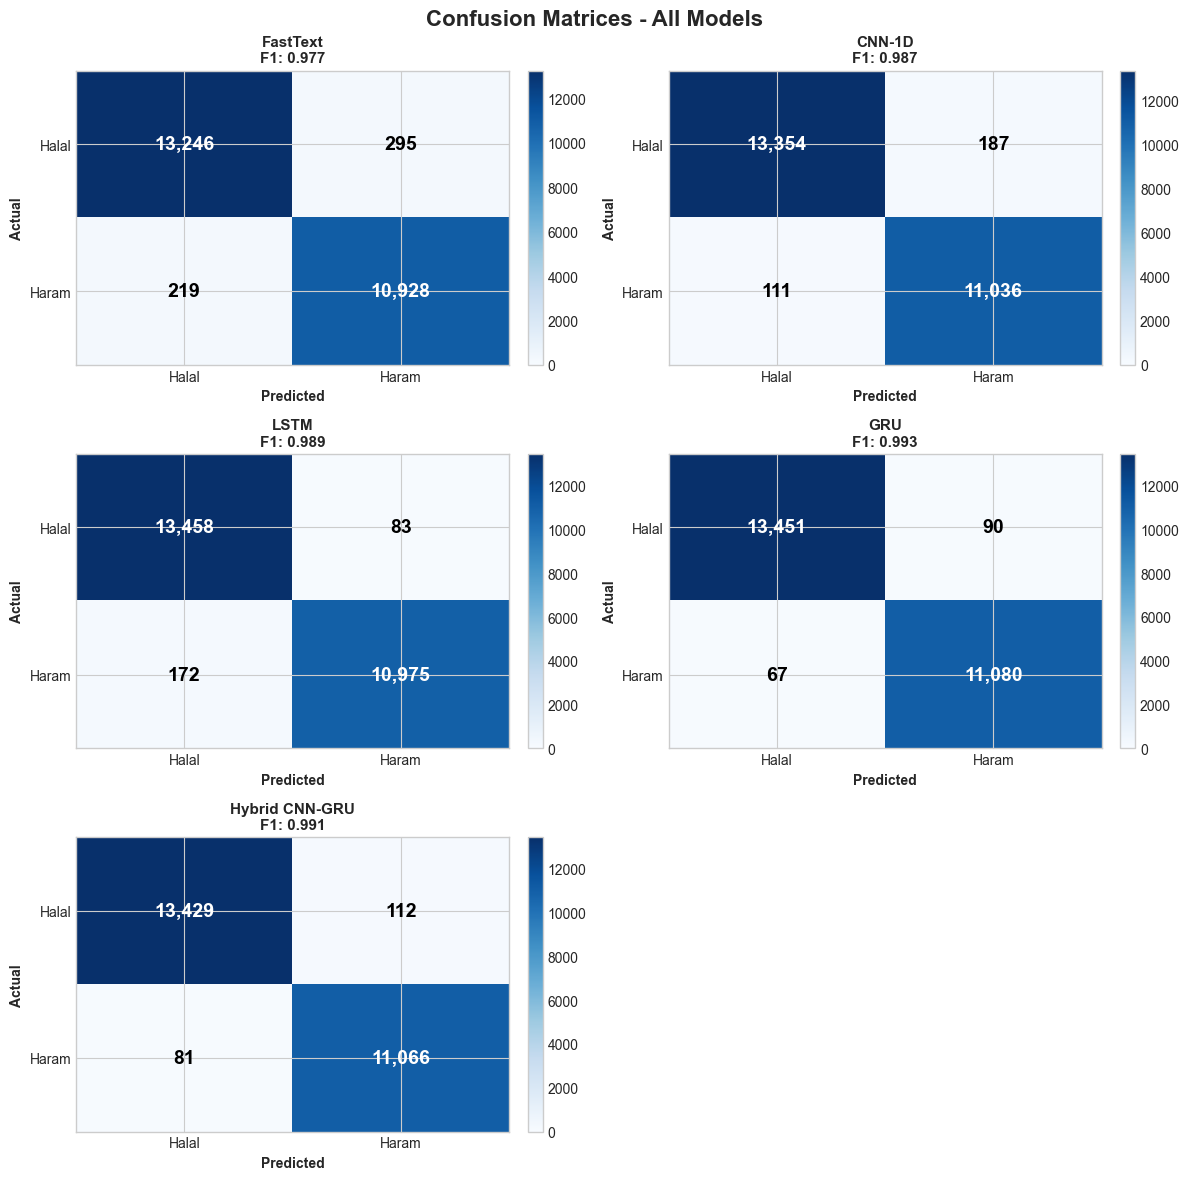

✅ Confusion matrices created!

🏆 Section 4: Overall Model Ranking...


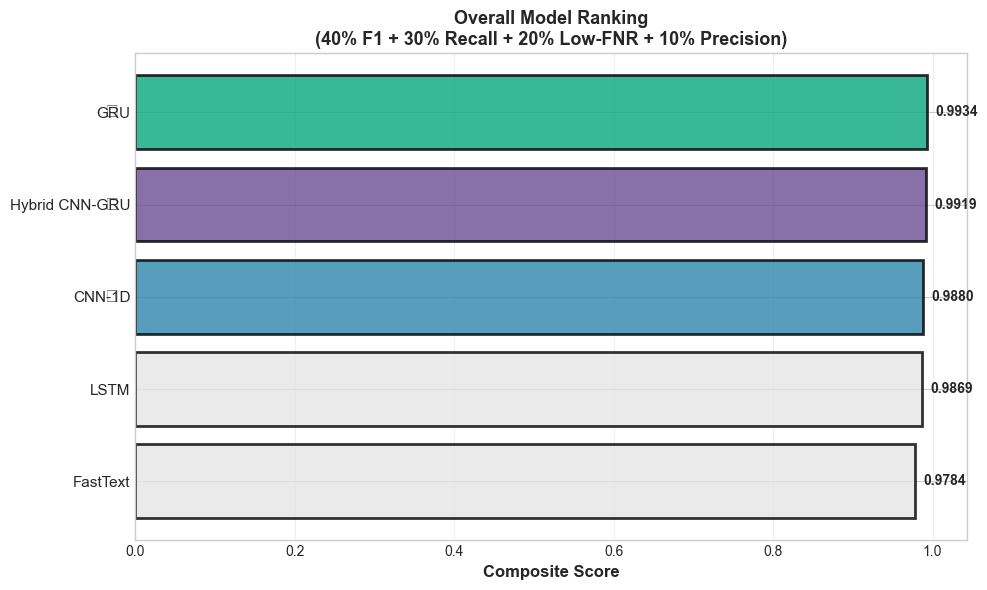

✅ Model ranking created!

✅ VISUALIZATION COMPLETE!

📊 Created Visualizations:
   1. training_history.png - Training curves (accuracy, loss, precision, recall)
   2. model_comparison.png - 6 key metrics comparison
   3. confusion_matrices.png - Confusion matrices for all models
   4. model_ranking.png - Overall ranking with composite score

🎨 Color Scheme:
   • Blue: Primary metrics (F1, accuracy)
   • Green: Good performance (recall, success)
   • Orange: Time/efficiency metrics
   • Red: Critical metrics (FNR)
   • Purple: Model characteristics (size, parameters)

📁 All visualizations saved in 'results/' folder



In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# ============================================================================
# SETUP PLOTTING STYLE
# ============================================================================

print("📊 CREATING COMPREHENSIVE VISUALIZATION DASHBOARD")
print("=" * 80)

# Simple, professional color scheme
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# Professional color palette
COLORS = {
    'primary': '#2E86AB',      # Blue
    'secondary': '#A23B72',    # Purple
    'success': '#06A77D',      # Green
    'warning': '#F18F01',      # Orange
    'danger': '#C73E1D',       # Red
    'info': '#6A4C93',         # Dark purple
    'light': '#E5E5E5',        # Light gray
    'dark': '#2D3142'          # Dark gray
}

os.makedirs('results', exist_ok=True)

# ============================================================================
# SECTION 1: TRAINING HISTORY
# ============================================================================

print("\n📈 Section 1: Training History Analysis...")

try:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Training History - All Models', fontsize=16, fontweight='bold')
    
    model_colors = [COLORS['primary'], COLORS['success'], COLORS['warning'], COLORS['danger']]
    
    for idx, (name, history) in enumerate(training_histories.items()):
        color = model_colors[idx % len(model_colors)]
        
        # Accuracy
        axes[0, 0].plot(history['accuracy'], label=f'{name} Train', 
                       color=color, linewidth=2, alpha=0.8)
        axes[0, 0].plot(history['val_accuracy'], label=f'{name} Val', 
                       color=color, linewidth=2, linestyle='--', alpha=0.6)
    
    axes[0, 0].set_title('Accuracy Over Epochs', fontweight='bold', fontsize=12)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend(loc='best', fontsize=8)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    for idx, (name, history) in enumerate(training_histories.items()):
        color = model_colors[idx % len(model_colors)]
        axes[0, 1].plot(history['loss'], label=f'{name} Train', 
                       color=color, linewidth=2, alpha=0.8)
        axes[0, 1].plot(history['val_loss'], label=f'{name} Val', 
                       color=color, linewidth=2, linestyle='--', alpha=0.6)
    
    axes[0, 1].set_title('Loss Over Epochs', fontweight='bold', fontsize=12)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend(loc='best', fontsize=8)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision
    for idx, (name, history) in enumerate(training_histories.items()):
        color = model_colors[idx % len(model_colors)]
        if 'precision' in history:
            axes[1, 0].plot(history['precision'], label=f'{name} Train', 
                           color=color, linewidth=2, alpha=0.8)
            axes[1, 0].plot(history['val_precision'], label=f'{name} Val', 
                           color=color, linewidth=2, linestyle='--', alpha=0.6)
    
    axes[1, 0].set_title('Precision Over Epochs', fontweight='bold', fontsize=12)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend(loc='best', fontsize=8)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall
    for idx, (name, history) in enumerate(training_histories.items()):
        color = model_colors[idx % len(model_colors)]
        if 'recall' in history:
            axes[1, 1].plot(history['recall'], label=f'{name} Train', 
                           color=color, linewidth=2, alpha=0.8)
            axes[1, 1].plot(history['val_recall'], label=f'{name} Val', 
                           color=color, linewidth=2, linestyle='--', alpha=0.6)
    
    axes[1, 1].set_title('Recall Over Epochs', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend(loc='best', fontsize=8)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/training_history.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("✅ Training history plots created!")
    
except Exception as e:
    print(f"⚠️ Error: {e}")

# ============================================================================
# SECTION 2: MODEL COMPARISON (6 KEY METRICS)
# ============================================================================

print("\n📊 Section 2: Model Comparison Dashboard...")

try:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Model Comparison - Key Metrics', fontsize=16, fontweight='bold')
    
    models = list(results.keys())
    
    # 1. F1-Score
    f1_scores = [results[m]['f1_score'] for m in models]
    bars = axes[0, 0].bar(range(len(models)), f1_scores, color=COLORS['primary'], 
                          edgecolor='black', linewidth=1.5, alpha=0.8)
    axes[0, 0].set_title('F1-Score (Higher is Better)', fontweight='bold', fontsize=11)
    axes[0, 0].set_ylabel('F1-Score')
    axes[0, 0].set_xticks(range(len(models)))
    axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].set_ylim([min(f1_scores)*0.95, max(f1_scores)*1.05])
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, f1_scores)):
        axes[0, 0].text(i, val + 0.005, f'{val:.3f}', 
                       ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Highlight best
    best_idx = f1_scores.index(max(f1_scores))
    bars[best_idx].set_color(COLORS['success'])
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)
    
    # 2. Accuracy
    accuracies = [results[m]['accuracy'] for m in models]
    bars = axes[0, 1].bar(range(len(models)), accuracies, color=COLORS['success'], 
                          edgecolor='black', linewidth=1.5, alpha=0.8)
    axes[0, 1].set_title('Accuracy', fontweight='bold', fontsize=11)
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_xticks(range(len(models)))
    axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
    axes[0, 1].grid(axis='y', alpha=0.3)
    axes[0, 1].set_ylim([min(accuracies)*0.95, max(accuracies)*1.05])
    
    for i, (bar, val) in enumerate(zip(bars, accuracies)):
        axes[0, 1].text(i, val + 0.005, f'{val:.3f}', 
                       ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 3. Precision vs Recall
    precisions = [results[m]['precision'] for m in models]
    recalls = [results[m]['recall'] for m in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = axes[0, 2].bar(x - width/2, precisions, width, label='Precision',
                           color=COLORS['info'], edgecolor='black', linewidth=1.5, alpha=0.8)
    bars2 = axes[0, 2].bar(x + width/2, recalls, width, label='Recall',
                           color=COLORS['warning'], edgecolor='black', linewidth=1.5, alpha=0.8)
    
    axes[0, 2].set_title('Precision vs Recall', fontweight='bold', fontsize=11)
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels(models, rotation=45, ha='right')
    axes[0, 2].legend(loc='lower right')
    axes[0, 2].grid(axis='y', alpha=0.3)
    
    # 4. False Negative Rate (CRITICAL)
    fnr = [results[m]['false_negative_rate'] for m in models]
    bars = axes[1, 0].bar(range(len(models)), fnr, color=COLORS['danger'], 
                          edgecolor='black', linewidth=1.5, alpha=0.8)
    axes[1, 0].axhline(y=0.05, color='red', linestyle='--', linewidth=2, 
                      label='Target: 5%', alpha=0.7)
    axes[1, 0].set_title('False Negative Rate (Lower is Better)', 
                        fontweight='bold', fontsize=11)
    axes[1, 0].set_ylabel('FNR')
    axes[1, 0].set_xticks(range(len(models)))
    axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
    axes[1, 0].legend(loc='upper right')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars, fnr)):
        axes[1, 0].text(i, val + 0.002, f'{val:.1%}', 
                       ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Highlight models below 5%
    for i, val in enumerate(fnr):
        if val <= 0.05:
            bars[i].set_color(COLORS['success'])
    
    # 5. Model Size
    sizes = [results[m]['model_size_kb'] for m in models]
    bars = axes[1, 1].bar(range(len(models)), sizes, color=COLORS['secondary'], 
                          edgecolor='black', linewidth=1.5, alpha=0.8)
    axes[1, 1].set_title('Model Size (Lower is Better)', fontweight='bold', fontsize=11)
    axes[1, 1].set_ylabel('Size (KB)')
    axes[1, 1].set_xticks(range(len(models)))
    axes[1, 1].set_xticklabels(models, rotation=45, ha='right')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars, sizes)):
        axes[1, 1].text(i, val + max(sizes)*0.02, f'{val:.0f}', 
                       ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 6. Training Time
    times = [results[m]['train_time_sec'] for m in models]
    bars = axes[1, 2].bar(range(len(models)), times, color=COLORS['warning'], 
                          edgecolor='black', linewidth=1.5, alpha=0.8)
    axes[1, 2].set_title('Training Time (Lower is Better)', fontweight='bold', fontsize=11)
    axes[1, 2].set_ylabel('Time (seconds)')
    axes[1, 2].set_xticks(range(len(models)))
    axes[1, 2].set_xticklabels(models, rotation=45, ha='right')
    axes[1, 2].grid(axis='y', alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars, times)):
        axes[1, 2].text(i, val + max(times)*0.02, f'{val:.0f}s', 
                       ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('results/model_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("✅ Model comparison dashboard created!")
    
except Exception as e:
    print(f"⚠️ Error: {e}")

# ============================================================================
# SECTION 3: CONFUSION MATRICES
# ============================================================================

print("\n🔍 Section 3: Confusion Matrices...")

try:
    n_models = len(models)
    n_cols = 2
    n_rows = (n_models + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*4))
    fig.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold')
    
    axes = axes.flatten() if n_models > 1 else [axes]
    
    for idx, model_name in enumerate(models):
        cm = np.array([
            [results[model_name]['true_negative'], results[model_name]['false_positive']],
            [results[model_name]['false_negative'], results[model_name]['true_positive']]
        ])
        
        # Simple heatmap
        im = axes[idx].imshow(cm, cmap='Blues', aspect='auto', vmin=0, vmax=cm.max())
        
        # Add text annotations
        for i in range(2):
            for j in range(2):
                text_color = 'white' if cm[i, j] > cm.max()/2 else 'black'
                axes[idx].text(j, i, f'{cm[i, j]:,}', 
                             ha='center', va='center', 
                             fontsize=14, fontweight='bold', color=text_color)
        
        axes[idx].set_xticks([0, 1])
        axes[idx].set_yticks([0, 1])
        axes[idx].set_xticklabels(['Halal', 'Haram'], fontsize=10)
        axes[idx].set_yticklabels(['Halal', 'Haram'], fontsize=10)
        axes[idx].set_xlabel('Predicted', fontweight='bold')
        axes[idx].set_ylabel('Actual', fontweight='bold')
        axes[idx].set_title(f'{model_name}\nF1: {results[model_name]["f1_score"]:.3f}', 
                           fontweight='bold', fontsize=11)
        
        # Add colorbar
        plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    
    # Hide unused subplots
    for idx in range(len(models), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('results/confusion_matrices.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("✅ Confusion matrices created!")
    
except Exception as e:
    print(f"⚠️ Error: {e}")

# ============================================================================
# SECTION 4: OVERALL RANKING
# ============================================================================

print("\n🏆 Section 4: Overall Model Ranking...")

try:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calculate composite score
    scores = []
    for model_name in models:
        score = (
            0.40 * results[model_name]['f1_score'] +
            0.30 * results[model_name]['recall'] +
            0.20 * (1 - results[model_name]['false_negative_rate']) +
            0.10 * results[model_name]['precision']
        )
        scores.append(score)
    
    # Sort by score
    sorted_indices = np.argsort(scores)[::-1]
    sorted_models = [models[i] for i in sorted_indices]
    sorted_scores = [scores[i] for i in sorted_indices]
    
    # Create horizontal bar chart
    colors_ranked = [COLORS['success'] if i == 0 else 
                    COLORS['info'] if i == 1 else 
                    COLORS['primary'] if i == 2 else 
                    COLORS['light'] for i in range(len(sorted_models))]
    
    bars = ax.barh(range(len(sorted_models)), sorted_scores, 
                   color=colors_ranked, edgecolor='black', linewidth=2, alpha=0.8)
    
    ax.set_yticks(range(len(sorted_models)))
    ax.set_yticklabels(sorted_models, fontsize=11)
    ax.set_xlabel('Composite Score', fontweight='bold', fontsize=12)
    ax.set_title('Overall Model Ranking\n(40% F1 + 30% Recall + 20% Low-FNR + 10% Precision)', 
                fontweight='bold', fontsize=13)
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()
    
    # Add score labels
    for i, (bar, score) in enumerate(zip(bars, sorted_scores)):
        ax.text(score + 0.01, i, f'{score:.4f}', 
               va='center', fontweight='bold', fontsize=10)
        
        # Add rank medal
        if i == 0:
            ax.text(-0.02, i, '🥇', va='center', ha='right', fontsize=14)
        elif i == 1:
            ax.text(-0.02, i, '🥈', va='center', ha='right', fontsize=14)
        elif i == 2:
            ax.text(-0.02, i, '🥉', va='center', ha='right', fontsize=14)
    
    plt.tight_layout()
    plt.savefig('results/model_ranking.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("✅ Model ranking created!")
    
except Exception as e:
    print(f"⚠️ Error: {e}")

# ============================================================================
# SUMMARY
# ============================================================================

print(f"\n{'='*80}")
print("✅ VISUALIZATION COMPLETE!")
print('='*80)

print(f"""
📊 Created Visualizations:
   1. training_history.png - Training curves (accuracy, loss, precision, recall)
   2. model_comparison.png - 6 key metrics comparison
   3. confusion_matrices.png - Confusion matrices for all models
   4. model_ranking.png - Overall ranking with composite score

🎨 Color Scheme:
   • Blue: Primary metrics (F1, accuracy)
   • Green: Good performance (recall, success)
   • Orange: Time/efficiency metrics
   • Red: Critical metrics (FNR)
   • Purple: Model characteristics (size, parameters)

📁 All visualizations saved in 'results/' folder
""")

📊 CREATING INDIVIDUAL MODEL TRAINING PLOTS

📈 Creating plots for FastText...


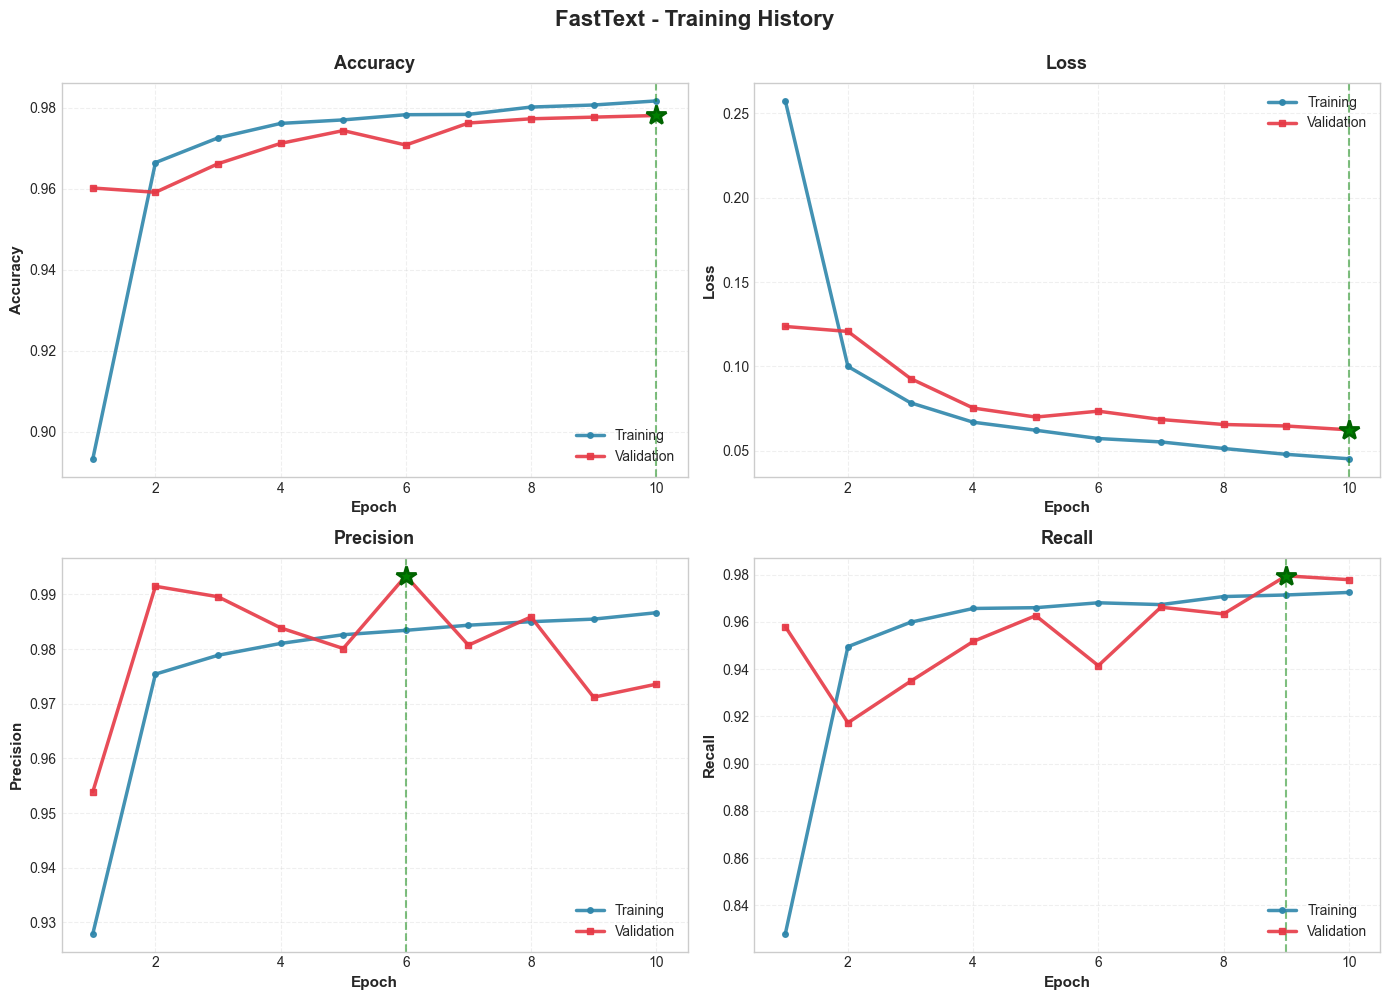

✅ Saved: results/individual_models/fasttext_training.png
   Creating detailed accuracy plot for FastText...
   ✅ Saved: results/individual_models/fasttext_accuracy_detailed.png

📈 Creating plots for CNN-1D...


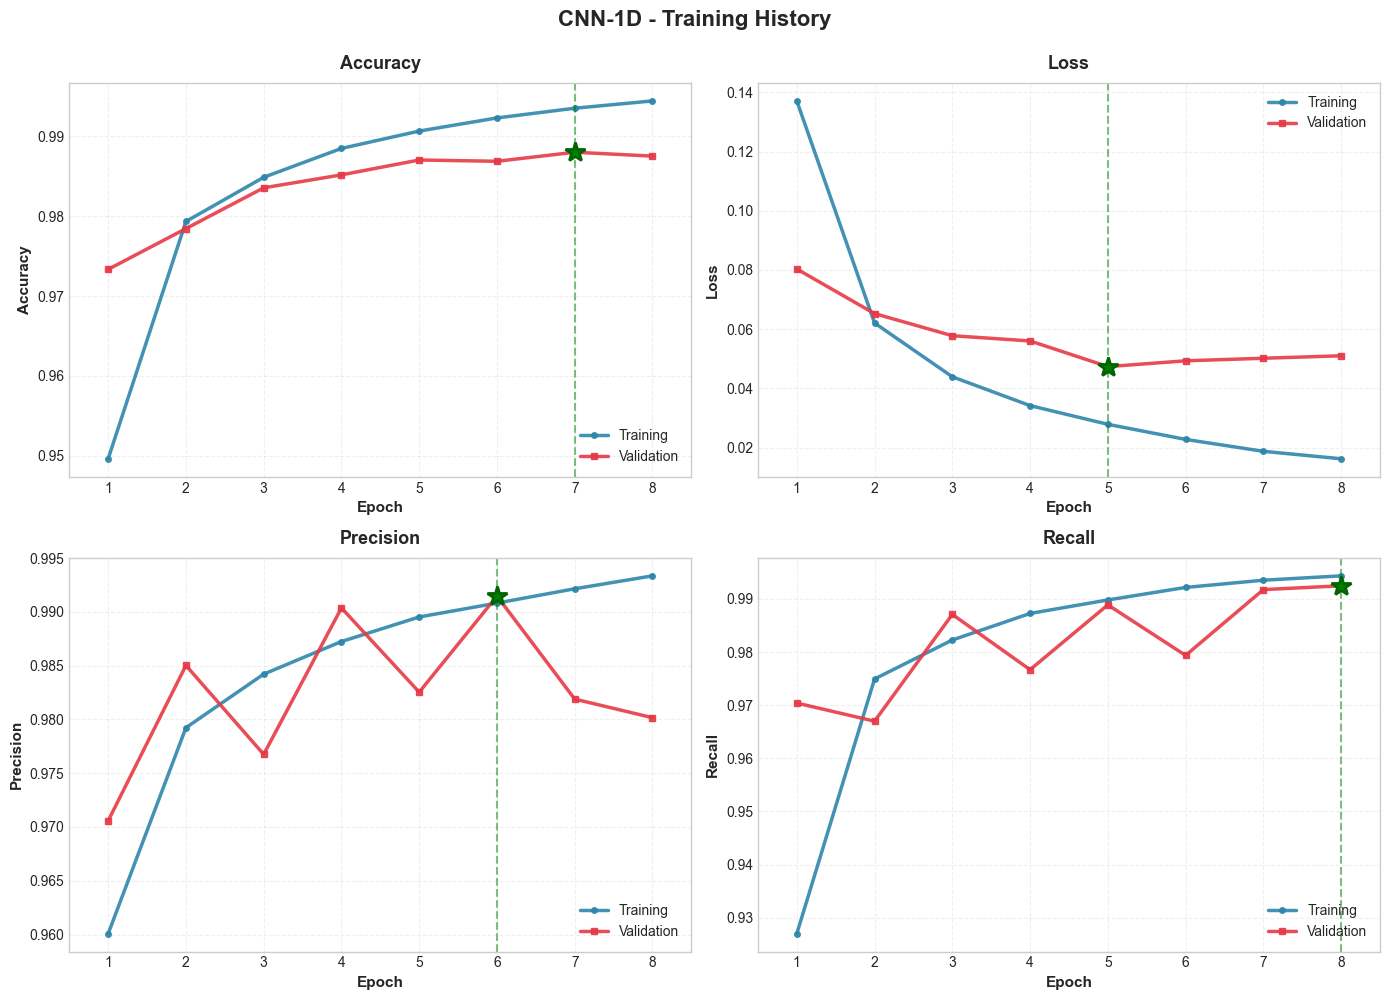

✅ Saved: results/individual_models/cnn_1d_training.png
   Creating detailed accuracy plot for CNN-1D...
   ✅ Saved: results/individual_models/cnn_1d_accuracy_detailed.png

📈 Creating plots for LSTM...


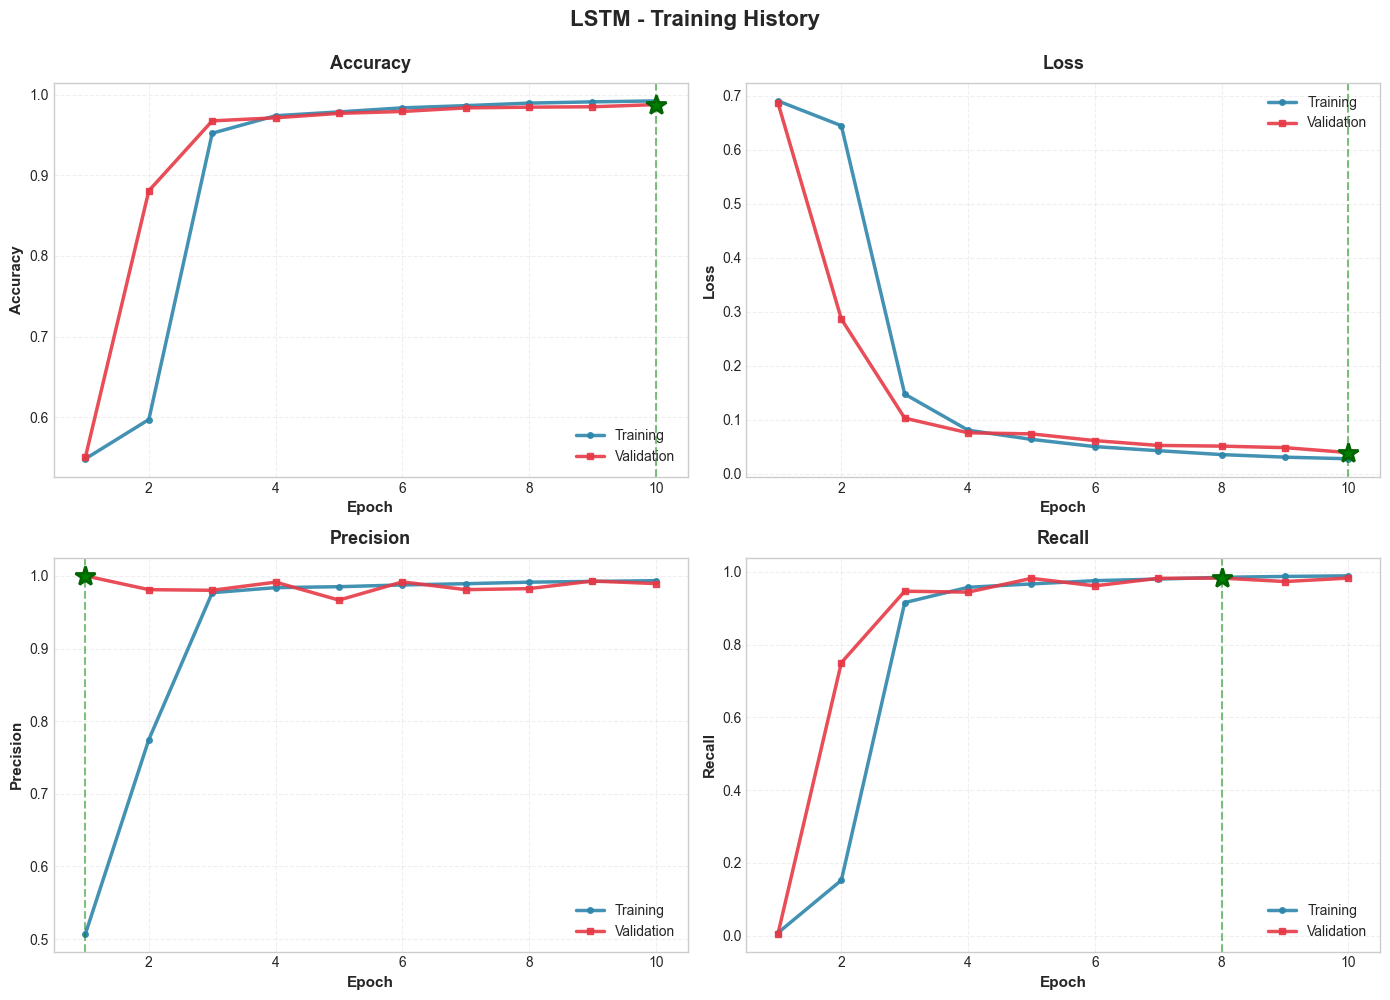

✅ Saved: results/individual_models/lstm_training.png
   Creating detailed accuracy plot for LSTM...
   ✅ Saved: results/individual_models/lstm_accuracy_detailed.png

📈 Creating plots for GRU...


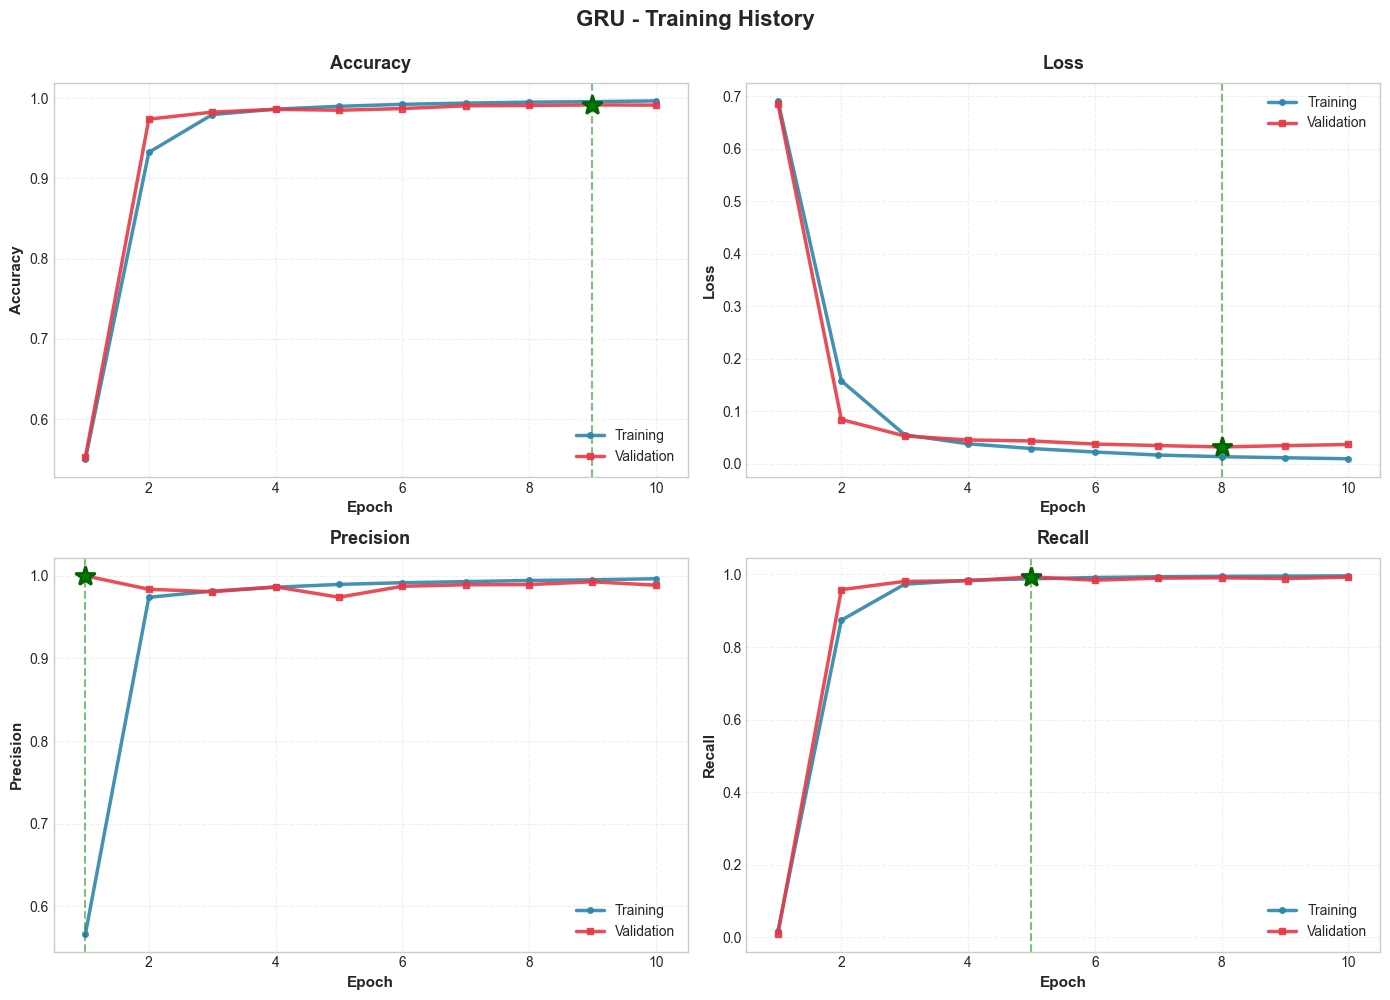

✅ Saved: results/individual_models/gru_training.png
   Creating detailed accuracy plot for GRU...
   ✅ Saved: results/individual_models/gru_accuracy_detailed.png

📈 Creating plots for Hybrid CNN-GRU...


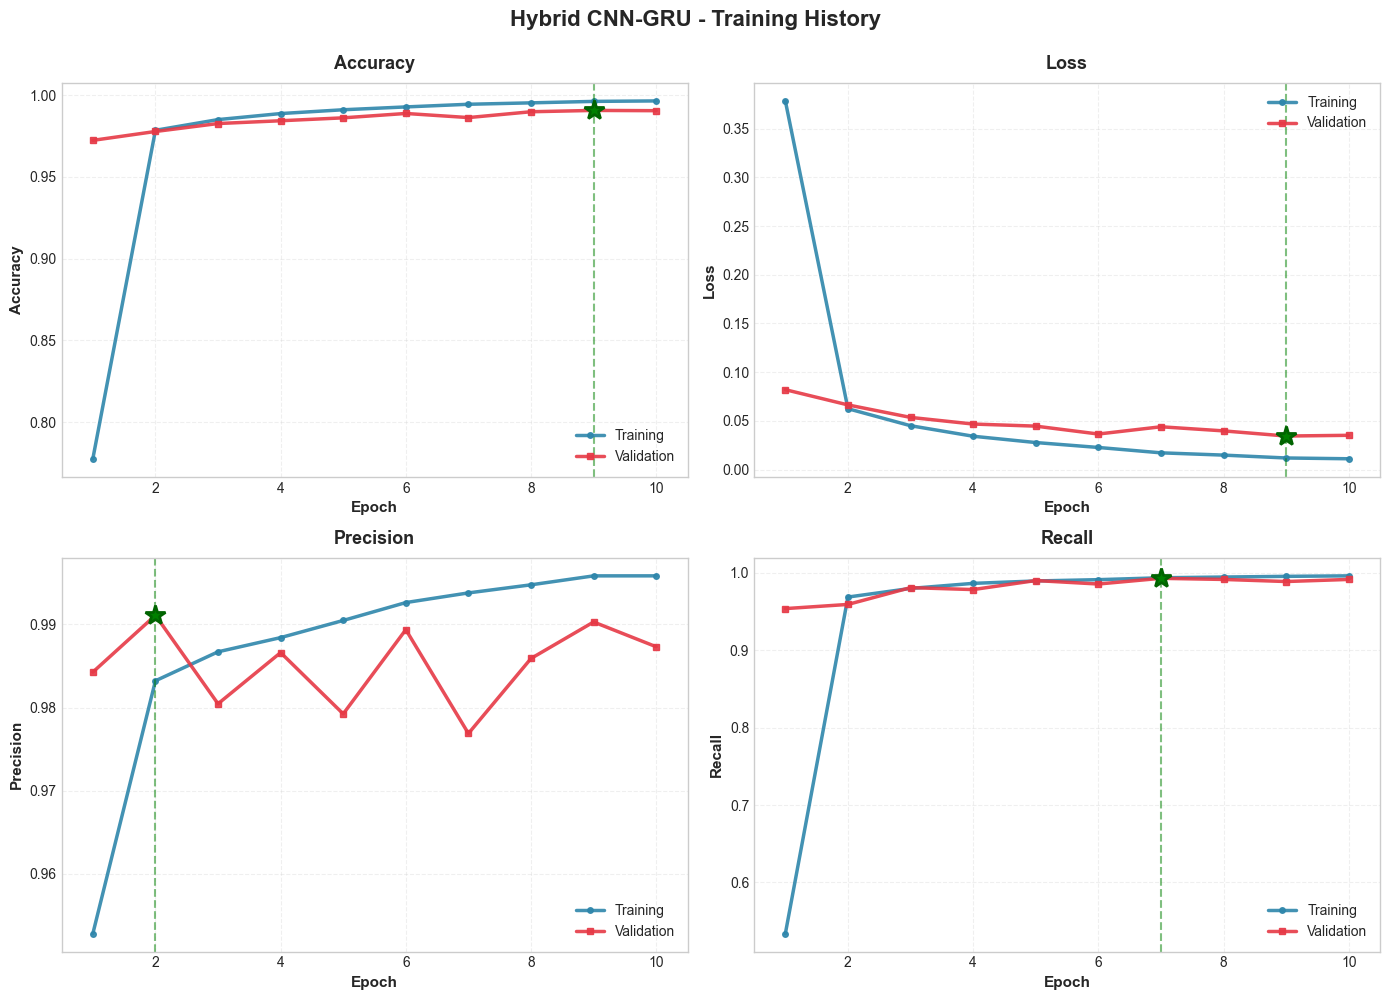

✅ Saved: results/individual_models/hybrid_cnn_gru_training.png
   Creating detailed accuracy plot for Hybrid CNN-GRU...
   ✅ Saved: results/individual_models/hybrid_cnn_gru_accuracy_detailed.png

✅ INDIVIDUAL MODEL PLOTS COMPLETE!

📊 Created Individual Training Plots:

For each model (5 total):
   1. Combined 2x2 plot (Accuracy, Loss, Precision, Recall)
   2. Detailed Accuracy plot (large, single metric)

📁 Location: results/individual_models/

Files created:

   • fasttext_training.png
   • fasttext_accuracy_detailed.png
   • cnn_1d_training.png
   • cnn_1d_accuracy_detailed.png
   • lstm_training.png
   • lstm_accuracy_detailed.png
   • gru_training.png
   • gru_accuracy_detailed.png
   • hybrid_cnn_gru_training.png
   • hybrid_cnn_gru_accuracy_detailed.png

✨ Features:
   • Clean design without overlapping text
   • Blue (training) vs Red (validation)
   • Best epoch marked with green dashed line + star
   • Clear grid for easy reading
   • High resolution (300 DPI)
   • No cluttere

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os

print("📊 CREATING INDIVIDUAL MODEL TRAINING PLOTS")
print("=" * 80)

os.makedirs('results/individual_models', exist_ok=True)

# Professional colors
COLORS = {
    'train': '#2E86AB',      # Blue for training
    'val': '#E63946',        # Red for validation
    'grid': '#CCCCCC'        # Light gray for grid
}

# ============================================================================
# INDIVIDUAL MODEL PLOTS
# ============================================================================

for model_name, history in training_histories.items():
    print(f"\n📈 Creating plots for {model_name}...")
    
    # Create 2x2 subplot for each model
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{model_name} - Training History', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    epochs = range(1, len(history['accuracy']) + 1)
    
    # ========================================================================
    # 1. ACCURACY
    # ========================================================================
    ax1 = axes[0, 0]
    
    # Plot lines
    ax1.plot(epochs, history['accuracy'], 
            color=COLORS['train'], linewidth=2.5, 
            label='Training', marker='o', markersize=4, alpha=0.9)
    ax1.plot(epochs, history['val_accuracy'], 
            color=COLORS['val'], linewidth=2.5, 
            label='Validation', marker='s', markersize=4, alpha=0.9)
    
    # Best value annotation - just vertical line and star
    best_val_acc = max(history['val_accuracy'])
    best_epoch_acc = history['val_accuracy'].index(best_val_acc) + 1
    ax1.axvline(x=best_epoch_acc, color='green', linestyle='--', 
               linewidth=1.5, alpha=0.5)
    ax1.plot(best_epoch_acc, best_val_acc, 'g*', markersize=15, 
            markeredgecolor='darkgreen', markeredgewidth=2)
    
    ax1.set_title('Accuracy', fontsize=13, fontweight='bold', pad=10)
    ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax1.legend(loc='lower right', fontsize=10, framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--', color=COLORS['grid'])
    ax1.set_xlim([0.5, len(epochs) + 0.5])
    
    # ========================================================================
    # 2. LOSS
    # ========================================================================
    ax2 = axes[0, 1]
    
    ax2.plot(epochs, history['loss'], 
            color=COLORS['train'], linewidth=2.5, 
            label='Training', marker='o', markersize=4, alpha=0.9)
    ax2.plot(epochs, history['val_loss'], 
            color=COLORS['val'], linewidth=2.5, 
            label='Validation', marker='s', markersize=4, alpha=0.9)
    
    # Best value annotation
    best_val_loss = min(history['val_loss'])
    best_epoch_loss = history['val_loss'].index(best_val_loss) + 1
    ax2.axvline(x=best_epoch_loss, color='green', linestyle='--', 
               linewidth=1.5, alpha=0.5)
    ax2.plot(best_epoch_loss, best_val_loss, 'g*', markersize=15,
            markeredgecolor='darkgreen', markeredgewidth=2)
    
    ax2.set_title('Loss', fontsize=13, fontweight='bold', pad=10)
    ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Loss', fontsize=11, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10, framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle='--', color=COLORS['grid'])
    ax2.set_xlim([0.5, len(epochs) + 0.5])
    
    # ========================================================================
    # 3. PRECISION
    # ========================================================================
    ax3 = axes[1, 0]
    
    if 'precision' in history and 'val_precision' in history:
        ax3.plot(epochs, history['precision'], 
                color=COLORS['train'], linewidth=2.5, 
                label='Training', marker='o', markersize=4, alpha=0.9)
        ax3.plot(epochs, history['val_precision'], 
                color=COLORS['val'], linewidth=2.5, 
                label='Validation', marker='s', markersize=4, alpha=0.9)
        
        # Best value annotation
        best_val_prec = max(history['val_precision'])
        best_epoch_prec = history['val_precision'].index(best_val_prec) + 1
        ax3.axvline(x=best_epoch_prec, color='green', linestyle='--', 
                   linewidth=1.5, alpha=0.5)
        ax3.plot(best_epoch_prec, best_val_prec, 'g*', markersize=15,
                markeredgecolor='darkgreen', markeredgewidth=2)
        
        ax3.legend(loc='lower right', fontsize=10, framealpha=0.9)
    else:
        ax3.text(0.5, 0.5, 'Precision not available', 
                transform=ax3.transAxes, ha='center', va='center',
                fontsize=12, color='gray', style='italic')
    
    ax3.set_title('Precision', fontsize=13, fontweight='bold', pad=10)
    ax3.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Precision', fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3, linestyle='--', color=COLORS['grid'])
    ax3.set_xlim([0.5, len(epochs) + 0.5])
    
    # ========================================================================
    # 4. RECALL
    # ========================================================================
    ax4 = axes[1, 1]
    
    if 'recall' in history and 'val_recall' in history:
        ax4.plot(epochs, history['recall'], 
                color=COLORS['train'], linewidth=2.5, 
                label='Training', marker='o', markersize=4, alpha=0.9)
        ax4.plot(epochs, history['val_recall'], 
                color=COLORS['val'], linewidth=2.5, 
                label='Validation', marker='s', markersize=4, alpha=0.9)
        
        # Best value annotation
        best_val_rec = max(history['val_recall'])
        best_epoch_rec = history['val_recall'].index(best_val_rec) + 1
        ax4.axvline(x=best_epoch_rec, color='green', linestyle='--', 
                   linewidth=1.5, alpha=0.5)
        ax4.plot(best_epoch_rec, best_val_rec, 'g*', markersize=15,
                markeredgecolor='darkgreen', markeredgewidth=2)
        
        ax4.legend(loc='lower right', fontsize=10, framealpha=0.9)
    else:
        ax4.text(0.5, 0.5, 'Recall not available', 
                transform=ax4.transAxes, ha='center', va='center',
                fontsize=12, color='gray', style='italic')
    
    ax4.set_title('Recall', fontsize=13, fontweight='bold', pad=10)
    ax4.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Recall', fontsize=11, fontweight='bold')
    ax4.grid(True, alpha=0.3, linestyle='--', color=COLORS['grid'])
    ax4.set_xlim([0.5, len(epochs) + 0.5])
    
    # ========================================================================
    # SAVE
    # ========================================================================
    plt.tight_layout()
    
    # Save with model name in filename
    filename = f'results/individual_models/{model_name.lower().replace(" ", "_").replace("-", "_")}_training.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"✅ Saved: {filename}")
    
    # ========================================================================
    # DETAILED ACCURACY PLOT (Single, Large)
    # ========================================================================
    
    print(f"   Creating detailed accuracy plot for {model_name}...")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot lines
    ax.plot(epochs, history['accuracy'], 
           color=COLORS['train'], linewidth=3, 
           label='Training', marker='o', markersize=5, alpha=0.9)
    ax.plot(epochs, history['val_accuracy'], 
           color=COLORS['val'], linewidth=3, 
           label='Validation', marker='s', markersize=5, alpha=0.9)
    
    # Best epoch marker
    best_val_acc = max(history['val_accuracy'])
    best_epoch = history['val_accuracy'].index(best_val_acc) + 1
    ax.axvline(x=best_epoch, color='green', linestyle='--', 
              linewidth=2, alpha=0.5, label=f'Best Epoch: {best_epoch}')
    ax.plot(best_epoch, best_val_acc, 'g*', markersize=20,
           markeredgecolor='darkgreen', markeredgewidth=2)
    
    ax.set_title(f'{model_name} - Accuracy Over Epochs', 
                fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim([0.5, len(epochs) + 0.5])
    
    plt.tight_layout()
    filename = f'results/individual_models/{model_name.lower().replace(" ", "_").replace("-", "_")}_accuracy_detailed.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    
    print(f"   ✅ Saved: {filename}")

# ============================================================================
# SUMMARY
# ============================================================================

print(f"\n{'='*80}")
print("✅ INDIVIDUAL MODEL PLOTS COMPLETE!")
print('='*80)

print(f"""
📊 Created Individual Training Plots:

For each model ({len(training_histories)} total):
   1. Combined 2x2 plot (Accuracy, Loss, Precision, Recall)
   2. Detailed Accuracy plot (large, single metric)

📁 Location: results/individual_models/

Files created:
""")

for model_name in training_histories.keys():
    clean_name = model_name.lower().replace(" ", "_").replace("-", "_")
    print(f"   • {clean_name}_training.png")
    print(f"   • {clean_name}_accuracy_detailed.png")

print(f"""
✨ Features:
   • Clean design without overlapping text
   • Blue (training) vs Red (validation)
   • Best epoch marked with green dashed line + star
   • Clear grid for easy reading
   • High resolution (300 DPI)
   • No cluttered annotations
""")

### Training History Visualization

📈 CREATING COMPREHENSIVE TRAINING HISTORY VISUALIZATION

🔍 Checking available variables...
✅ Found 'results' with 5 models
✅ Found 'training_histories' with 5 models

📊 Creating main training history plots...


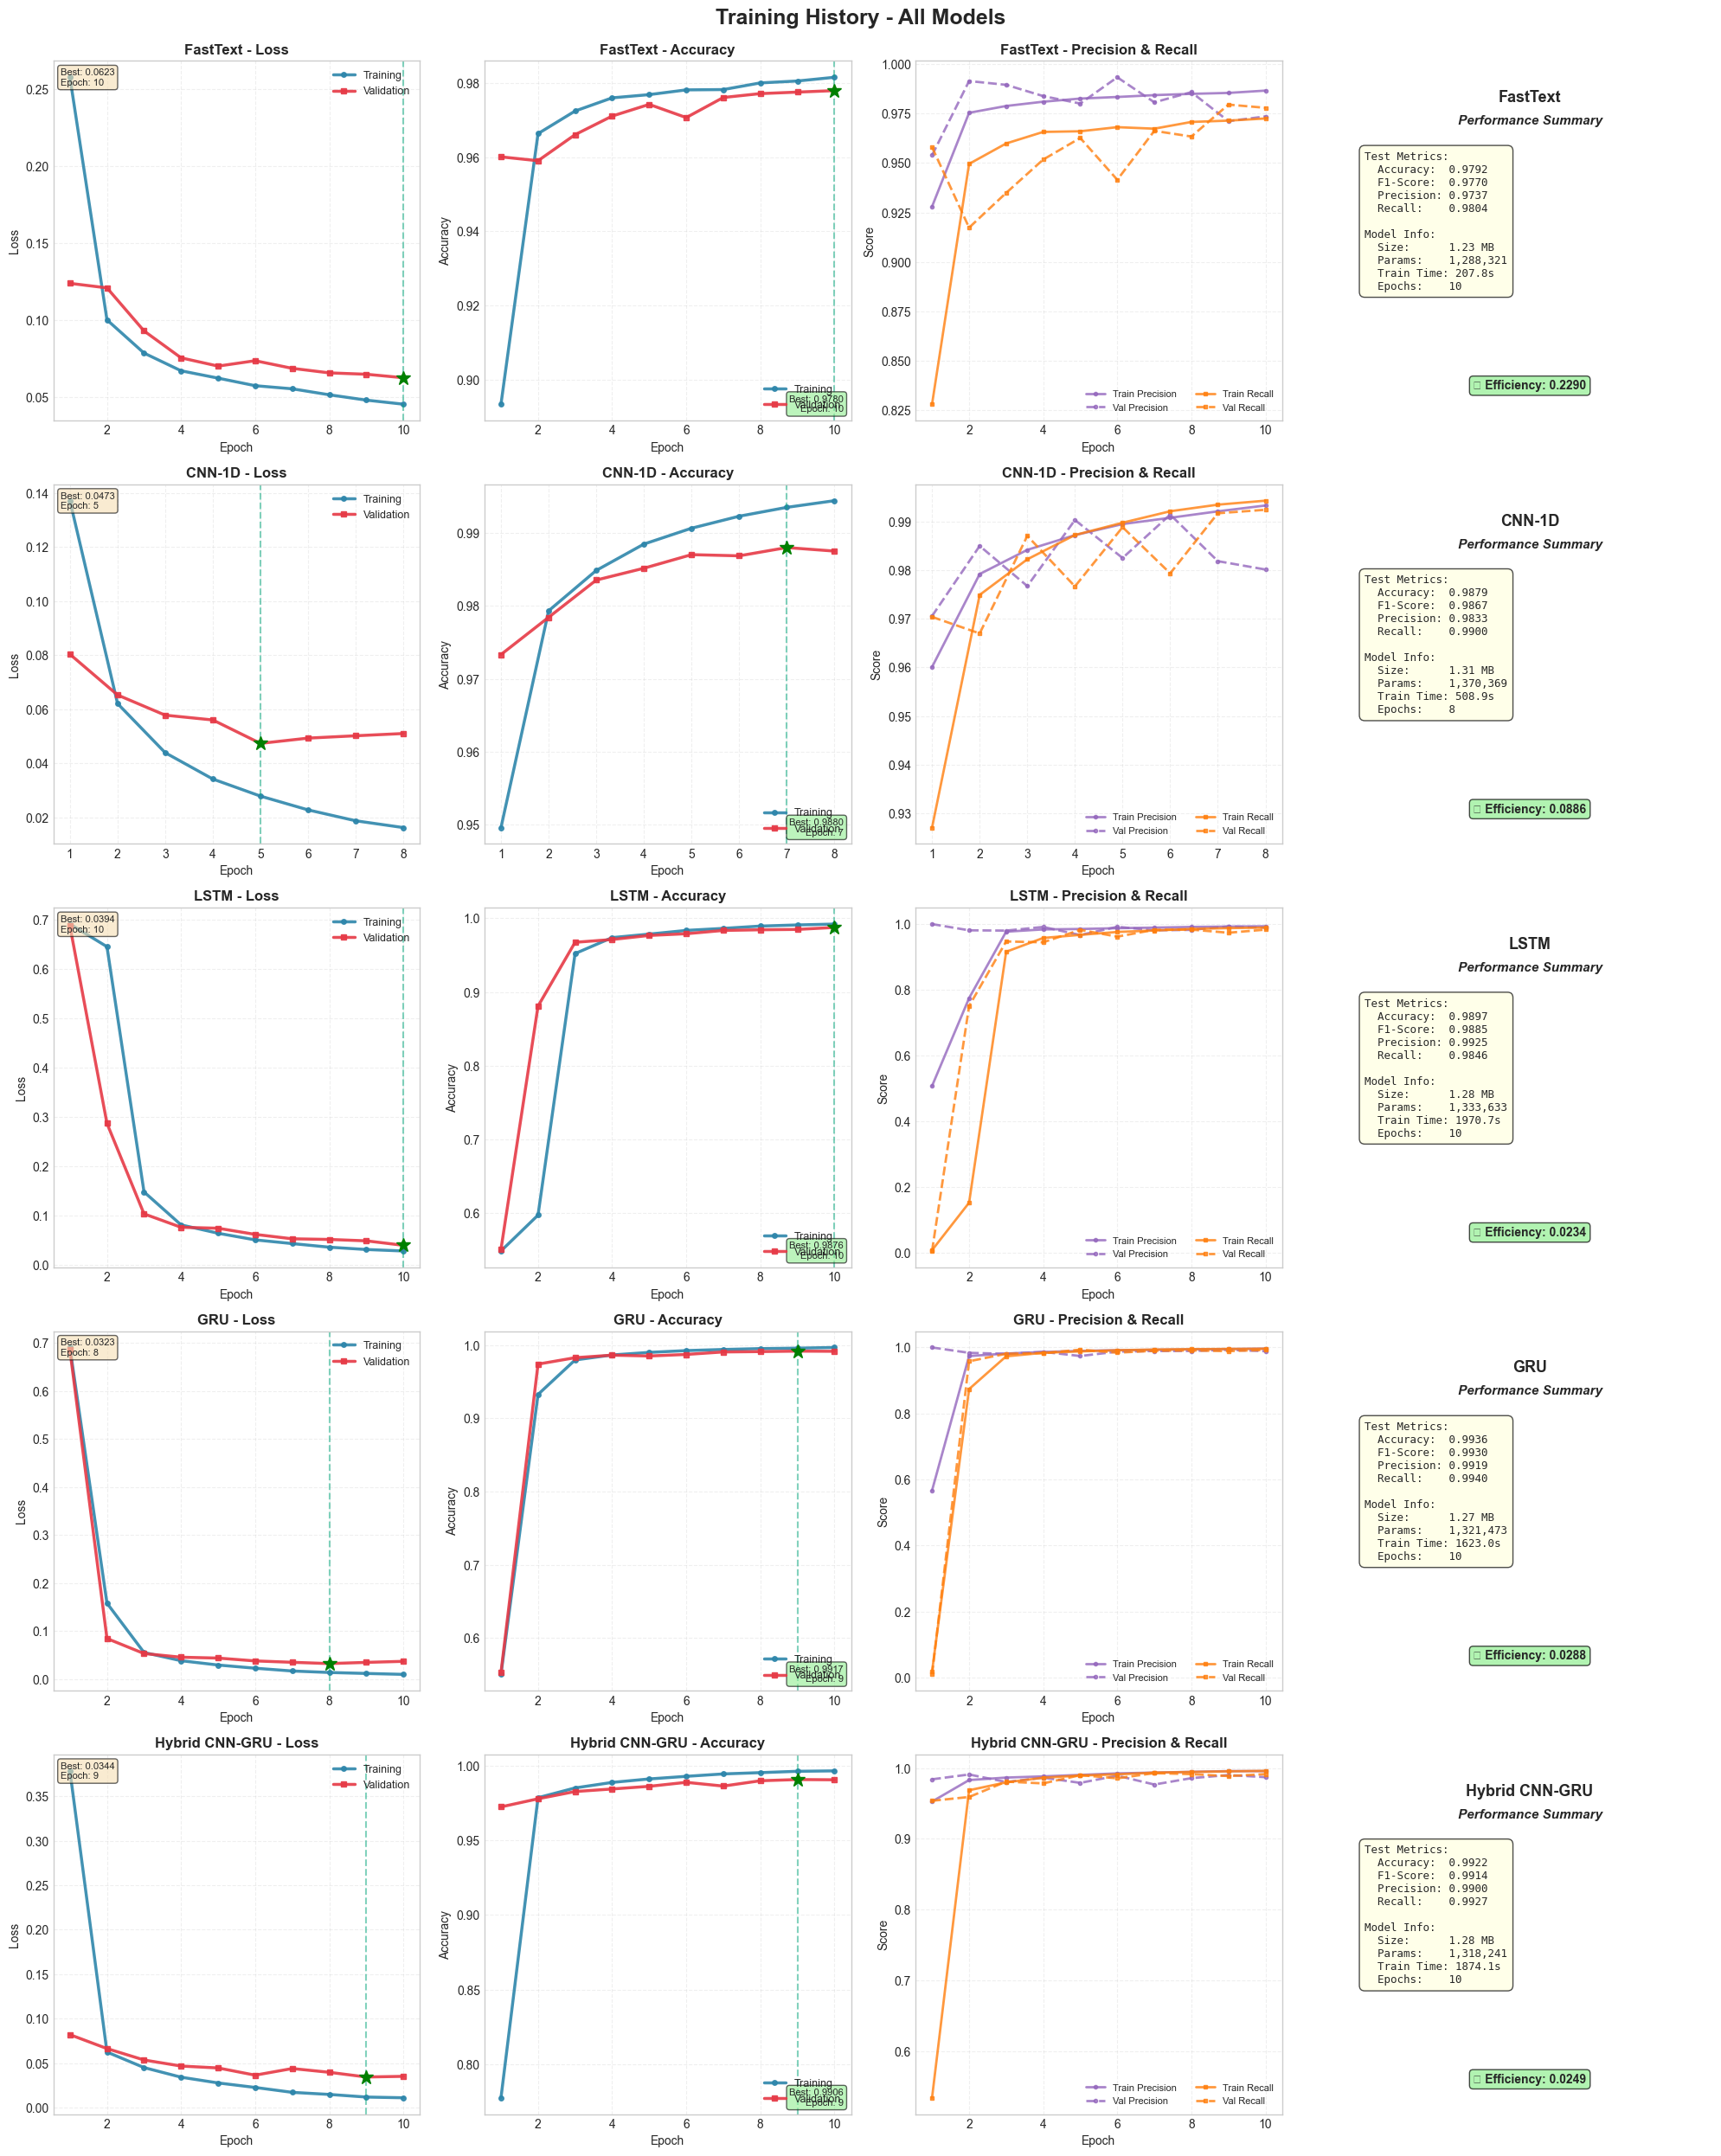

✅ Comprehensive training history created!

📊 Creating training summary comparison...


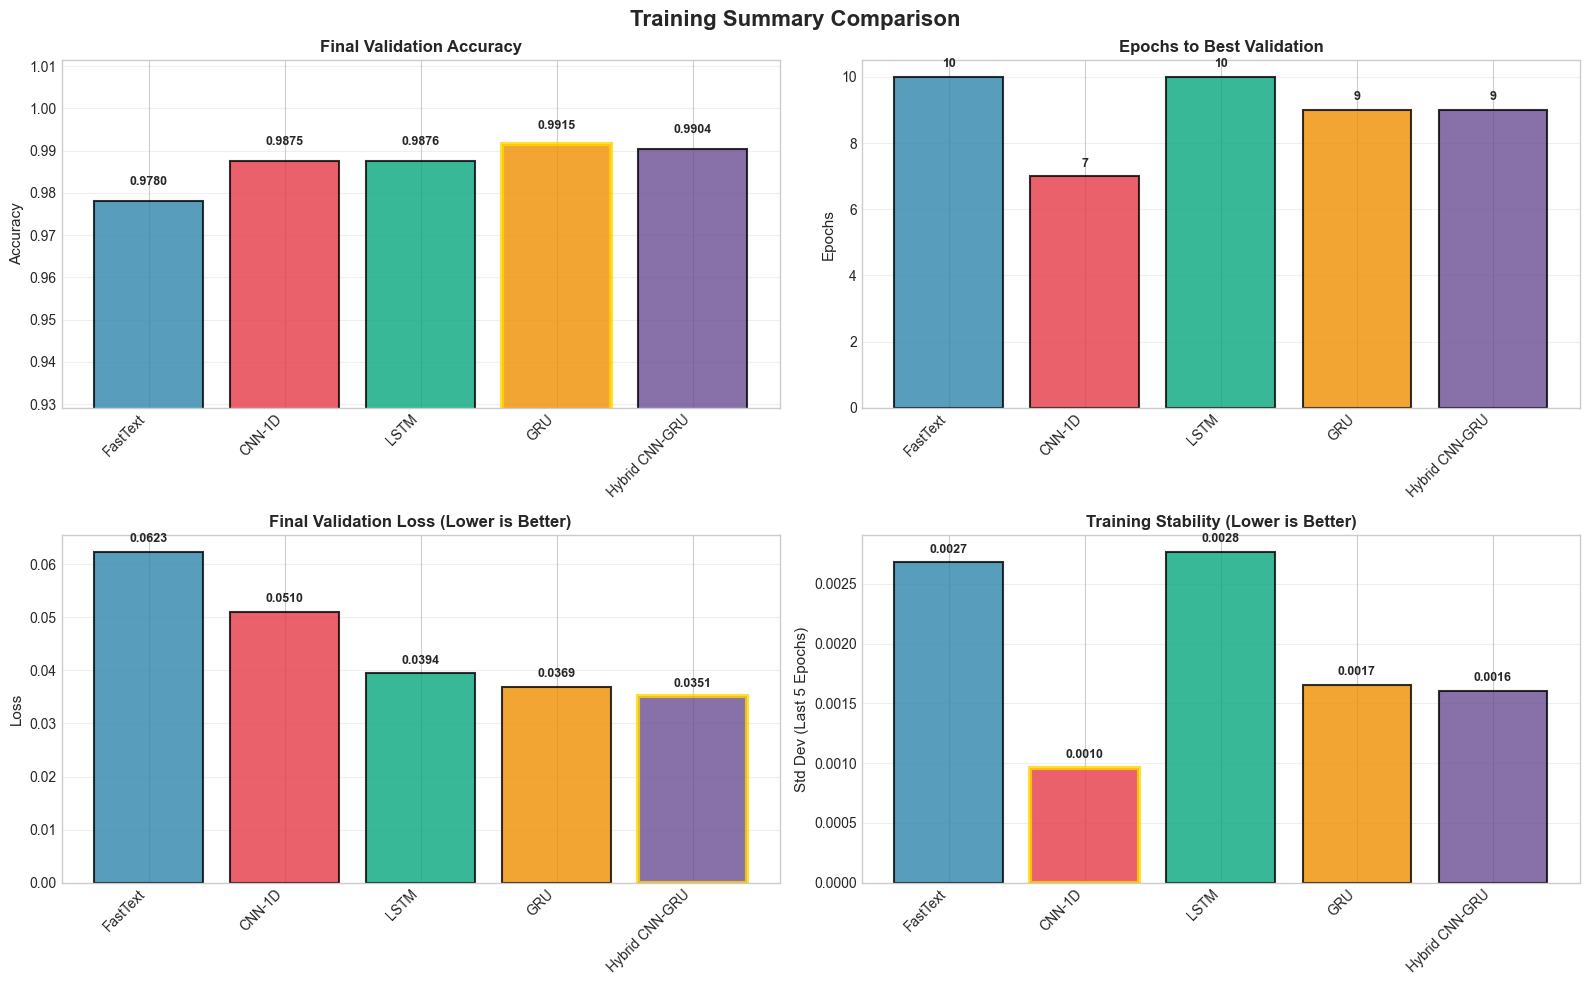

✅ Training summary comparison created!

✅ TRAINING HISTORY VISUALIZATION COMPLETE!

📊 Created Visualizations:
   1. comprehensive_training_history.png
      • Loss curves with best epoch markers
      • Accuracy curves with best epoch markers
      • Precision & Recall curves
      • Model performance summaries

   2. training_summary_comparison.png
      • Final validation accuracy comparison
      • Epochs to convergence
      • Final validation loss comparison
      • Training stability analysis

🎨 Design Features:
   • Clean, professional colors
   • Blue (training) vs Red (validation)
   • Gold borders highlight best models
   • Grid for easy reading
   • Value labels on all bars
   • High resolution (300 DPI)

📁 Location: results/



In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os

print("📈 CREATING COMPREHENSIVE TRAINING HISTORY VISUALIZATION")
print("=" * 80)

# Simple, professional colors
COLORS = {
    'train': '#2E86AB',      # Blue
    'val': '#E63946',        # Red
    'grid': '#CCCCCC',       # Gray
    'accent': '#06A77D'      # Green for highlights
}

os.makedirs('results', exist_ok=True)

# ============================================================================
# CHECK VARIABLES
# ============================================================================

print("\n🔍 Checking available variables...")

# Cek apakah 'results' ada (dari training loop)
if 'results' not in locals() and 'results' not in globals():
    print("❌ Error: 'results' dictionary not found!")
    print("   Make sure you ran the training loop first.")
    raise NameError("Variable 'results' is not defined. Run training first!")

# Cek apakah 'training_histories' ada
if 'training_histories' not in locals() and 'training_histories' not in globals():
    print("❌ Error: 'training_histories' dictionary not found!")
    print("   Make sure you ran the training loop first.")
    raise NameError("Variable 'training_histories' is not defined. Run training first!")

print(f"✅ Found 'results' with {len(results)} models")
print(f"✅ Found 'training_histories' with {len(training_histories)} models")

# Use the existing variables
models_dict = results
histories_dict = training_histories

# ============================================================================
# MAIN TRAINING HISTORY PLOTS (4 columns per model)
# ============================================================================

print("\n📊 Creating main training history plots...")

try:
    n_models = len(models_dict)
    fig, axes = plt.subplots(n_models, 4, figsize=(20, 5*n_models))
    fig.suptitle('Training History - All Models', fontsize=18, fontweight='bold', y=0.995)
    
    # Handle single model case
    if n_models == 1:
        axes = axes.reshape(1, -1)
    
    for i, model_name in enumerate(models_dict.keys()):
        # Get history from training_histories
        history = histories_dict[model_name]
        
        # Get results from results dict
        model_results = models_dict[model_name]
        
        epochs = range(1, len(history['loss']) + 1)
        
        # ====================================================================
        # 1. LOSS
        # ====================================================================
        ax = axes[i, 0]
        
        ax.plot(epochs, history['loss'], 
               color=COLORS['train'], linewidth=2.5, label='Training', 
               marker='o', markersize=4, alpha=0.9)
        ax.plot(epochs, history['val_loss'], 
               color=COLORS['val'], linewidth=2.5, label='Validation', 
               marker='s', markersize=4, alpha=0.9)
        
        # Best validation loss
        min_val_loss = min(history['val_loss'])
        min_val_epoch = history['val_loss'].index(min_val_loss) + 1
        ax.axvline(x=min_val_epoch, color=COLORS['accent'], 
                  linestyle='--', linewidth=1.5, alpha=0.5)
        ax.plot(min_val_epoch, min_val_loss, 'g*', markersize=12)
        
        ax.set_title(f'{model_name} - Loss', fontweight='bold', fontsize=12)
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel('Loss', fontsize=10)
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3, linestyle='--', color=COLORS['grid'])
        
        # Add text annotation
        textstr = f'Best: {min_val_loss:.4f}\nEpoch: {min_val_epoch}'
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, 
               fontsize=8, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))
        
        # ====================================================================
        # 2. ACCURACY
        # ====================================================================
        ax = axes[i, 1]
        
        ax.plot(epochs, history['accuracy'], 
               color=COLORS['train'], linewidth=2.5, label='Training', 
               marker='o', markersize=4, alpha=0.9)
        ax.plot(epochs, history['val_accuracy'], 
               color=COLORS['val'], linewidth=2.5, label='Validation', 
               marker='s', markersize=4, alpha=0.9)
        
        # Best validation accuracy
        max_val_acc = max(history['val_accuracy'])
        max_val_epoch = history['val_accuracy'].index(max_val_acc) + 1
        ax.axvline(x=max_val_epoch, color=COLORS['accent'], 
                  linestyle='--', linewidth=1.5, alpha=0.5)
        ax.plot(max_val_epoch, max_val_acc, 'g*', markersize=12)
        
        ax.set_title(f'{model_name} - Accuracy', fontweight='bold', fontsize=12)
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel('Accuracy', fontsize=10)
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3, linestyle='--', color=COLORS['grid'])
        
        # Add text annotation
        textstr = f'Best: {max_val_acc:.4f}\nEpoch: {max_val_epoch}'
        ax.text(0.98, 0.02, textstr, transform=ax.transAxes, 
               fontsize=8, verticalalignment='bottom', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.6))
        
        # ====================================================================
        # 3. PRECISION & RECALL
        # ====================================================================
        ax = axes[i, 2]
        
        if 'precision' in history and 'recall' in history:
            # Precision
            ax.plot(epochs, history['precision'], 
                   color='#9467bd', linewidth=2, label='Train Precision', 
                   marker='o', markersize=3, alpha=0.8)
            ax.plot(epochs, history['val_precision'], 
                   color='#9467bd', linewidth=2, label='Val Precision', 
                   linestyle='--', marker='o', markersize=3, alpha=0.8)
            
            # Recall
            ax.plot(epochs, history['recall'], 
                   color='#ff7f0e', linewidth=2, label='Train Recall', 
                   marker='s', markersize=3, alpha=0.8)
            ax.plot(epochs, history['val_recall'], 
                   color='#ff7f0e', linewidth=2, label='Val Recall', 
                   linestyle='--', marker='s', markersize=3, alpha=0.8)
            
            ax.set_title(f'{model_name} - Precision & Recall', fontweight='bold', fontsize=12)
            ax.set_xlabel('Epoch', fontsize=10)
            ax.set_ylabel('Score', fontsize=10)
            ax.legend(loc='lower right', fontsize=8, ncol=2)
            ax.grid(True, alpha=0.3, linestyle='--', color=COLORS['grid'])
            
        else:
            # Fallback: show model info
            info_text = f"""Model: {model_name}
            
Epochs: {len(epochs)}
Final Val Acc: {history['val_accuracy'][-1]:.4f}
Final Val Loss: {history['val_loss'][-1]:.4f}"""
            
            ax.text(0.5, 0.5, info_text, transform=ax.transAxes,
                   ha='center', va='center', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.6))
            ax.set_title(f'{model_name} - Training Info', fontweight='bold', fontsize=12)
            ax.axis('off')
        
        # ====================================================================
        # 4. MODEL SUMMARY
        # ====================================================================
        ax = axes[i, 3]
        ax.axis('off')
        
        # Title
        ax.text(0.5, 0.92, f'{model_name}', 
               ha='center', va='top', transform=ax.transAxes,
               fontsize=13, fontweight='bold')
        
        ax.text(0.5, 0.85, 'Performance Summary', 
               ha='center', va='top', transform=ax.transAxes,
               fontsize=11, fontweight='bold', style='italic')
        
        # Test metrics
        metrics_text = f"""Test Metrics:
  Accuracy:  {model_results['accuracy']:.4f}
  F1-Score:  {model_results['f1_score']:.4f}
  Precision: {model_results['precision']:.4f}
  Recall:    {model_results['recall']:.4f}
  
Model Info:
  Size:      {model_results['model_size_kb']/1024:.2f} MB
  Params:    {model_results['total_params']:,}
  Train Time: {model_results['train_time_sec']:.1f}s
  Epochs:    {model_results['epochs_trained']}"""
        
        ax.text(0.05, 0.75, metrics_text, 
               ha='left', va='top', transform=ax.transAxes,
               fontsize=9, family='monospace',
               bbox=dict(boxstyle='round', facecolor='lightyellow', 
                        alpha=0.7, pad=0.5))
        
        # Efficiency score
        efficiency = model_results['f1_score'] / ((model_results['model_size_kb']/1024) * model_results['train_time_sec'] / 60)
        
        ax.text(0.5, 0.08, f'⚡ Efficiency: {efficiency:.4f}', 
               ha='center', va='bottom', transform=ax.transAxes,
               fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    plt.tight_layout()
    plt.savefig('results/comprehensive_training_history.png', 
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("✅ Comprehensive training history created!")

except Exception as e:
    print(f"⚠️ Error creating training history: {e}")
    import traceback
    traceback.print_exc()

# ============================================================================
# TRAINING SUMMARY COMPARISON
# ============================================================================

print("\n📊 Creating training summary comparison...")

try:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Training Summary Comparison', fontsize=16, fontweight='bold')
    
    models_list = list(models_dict.keys())
    model_colors = ['#2E86AB', '#E63946', '#06A77D', '#F18F01', '#6A4C93']
    
    # ====================================================================
    # 1. FINAL VALIDATION ACCURACY
    # ====================================================================
    ax = axes[0, 0]
    
    final_val_acc = [histories_dict[m]['val_accuracy'][-1] for m in models_list]
    bars = ax.bar(range(len(models_list)), final_val_acc, 
                  color=model_colors[:len(models_list)], 
                  edgecolor='black', linewidth=1.5, alpha=0.8)
    
    ax.set_title('Final Validation Accuracy', fontweight='bold', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=11)
    ax.set_xticks(range(len(models_list)))
    ax.set_xticklabels(models_list, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([min(final_val_acc)*0.95, max(final_val_acc)*1.02])
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, final_val_acc)):
        ax.text(i, val + 0.003, f'{val:.4f}', 
               ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Highlight best
    best_idx = final_val_acc.index(max(final_val_acc))
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)
    
    # ====================================================================
    # 2. EPOCHS TO BEST VALIDATION
    # ====================================================================
    ax = axes[0, 1]
    
    epochs_to_best = []
    for model in models_list:
        val_acc = histories_dict[model]['val_accuracy']
        best_epoch = val_acc.index(max(val_acc)) + 1
        epochs_to_best.append(best_epoch)
    
    bars = ax.bar(range(len(models_list)), epochs_to_best, 
                  color=model_colors[:len(models_list)], 
                  edgecolor='black', linewidth=1.5, alpha=0.8)
    
    ax.set_title('Epochs to Best Validation', fontweight='bold', fontsize=12)
    ax.set_ylabel('Epochs', fontsize=11)
    ax.set_xticks(range(len(models_list)))
    ax.set_xticklabels(models_list, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars, epochs_to_best)):
        ax.text(i, val + 0.2, f'{val}', 
               ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # ====================================================================
    # 3. FINAL VALIDATION LOSS
    # ====================================================================
    ax = axes[1, 0]
    
    final_val_loss = [histories_dict[m]['val_loss'][-1] for m in models_list]
    bars = ax.bar(range(len(models_list)), final_val_loss, 
                  color=model_colors[:len(models_list)], 
                  edgecolor='black', linewidth=1.5, alpha=0.8)
    
    ax.set_title('Final Validation Loss (Lower is Better)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Loss', fontsize=11)
    ax.set_xticks(range(len(models_list)))
    ax.set_xticklabels(models_list, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars, final_val_loss)):
        ax.text(i, val + max(final_val_loss)*0.02, f'{val:.4f}', 
               ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Highlight best (lowest)
    best_idx = final_val_loss.index(min(final_val_loss))
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)
    
    # ====================================================================
    # 4. TRAINING STABILITY
    # ====================================================================
    ax = axes[1, 1]
    
    stability_scores = []
    for model in models_list:
        val_acc = histories_dict[model]['val_accuracy']
        # Use last 5 epochs
        last_epochs = val_acc[-5:] if len(val_acc) >= 5 else val_acc
        std_dev = np.std(last_epochs)
        stability_scores.append(std_dev)
    
    bars = ax.bar(range(len(models_list)), stability_scores, 
                  color=model_colors[:len(models_list)], 
                  edgecolor='black', linewidth=1.5, alpha=0.8)
    
    ax.set_title('Training Stability (Lower is Better)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Std Dev (Last 5 Epochs)', fontsize=11)
    ax.set_xticks(range(len(models_list)))
    ax.set_xticklabels(models_list, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars, stability_scores)):
        ax.text(i, val + max(stability_scores)*0.02, f'{val:.4f}', 
               ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Highlight most stable (lowest std)
    best_idx = stability_scores.index(min(stability_scores))
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)
    
    plt.tight_layout()
    plt.savefig('results/training_summary_comparison.png', 
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("✅ Training summary comparison created!")

except Exception as e:
    print(f"⚠️ Error creating summary comparison: {e}")
    import traceback
    traceback.print_exc()

# ============================================================================
# SUMMARY
# ============================================================================

print(f"\n{'='*80}")
print("✅ TRAINING HISTORY VISUALIZATION COMPLETE!")
print('='*80)

print(f"""
📊 Created Visualizations:
   1. comprehensive_training_history.png
      • Loss curves with best epoch markers
      • Accuracy curves with best epoch markers
      • Precision & Recall curves
      • Model performance summaries
      
   2. training_summary_comparison.png
      • Final validation accuracy comparison
      • Epochs to convergence
      • Final validation loss comparison
      • Training stability analysis

🎨 Design Features:
   • Clean, professional colors
   • Blue (training) vs Red (validation)
   • Gold borders highlight best models
   • Grid for easy reading
   • Value labels on all bars
   • High resolution (300 DPI)

📁 Location: results/
""")

## 📋 Experiment Conclusions

Pada bagian ini, kita akan merangkum hasil eksperimen dari semua model yang telah dilatih dan memberikan rekomendasi untuk langkah selanjutnya.

In [21]:
import pandas as pd
import numpy as np

print("📋 COMPREHENSIVE EXPERIMENT CONCLUSIONS")
print("=" * 80)

# ============================================================================
# VERIFY DATA AVAILABILITY
# ============================================================================

print("\n🔍 Checking available data...")

required_vars = ['results', 'training_histories']
missing_vars = []

for var in required_vars:
    if var not in locals() and var not in globals():
        missing_vars.append(var)

if missing_vars:
    print(f"❌ Error: Missing required variables: {missing_vars}")
    print("   Please run the training loop first!")
    raise NameError(f"Required variables not found: {missing_vars}")

print("✅ All required data available")

# ============================================================================
# CREATE RESULTS DATAFRAME
# ============================================================================

print("\n📊 Preparing results summary...")

# Convert results dict to DataFrame
results_list = []
for model_name, model_results in results.items():
    results_list.append({
        'Model': model_name,
        'Test_F1': model_results['f1_score'],
        'Test_Accuracy': model_results['accuracy'],
        'Test_Precision': model_results['precision'],
        'Test_Recall': model_results['recall'],
        'AUC': model_results['auc'],
        'Size_KB': model_results['model_size_kb'],
        'Size_MB': model_results['model_size_kb'] / 1024,
        'Parameters': model_results['total_params'],
        'Training_Time_sec': model_results['train_time_sec'],
        'FNR': model_results['false_negative_rate'],
        'Specificity': model_results['specificity'],
    })

results_df = pd.DataFrame(results_list)

# Sort by F1-Score
results_df = results_df.sort_values('Test_F1', ascending=False).reset_index(drop=True)

print(f"✅ Processed {len(results_df)} models")

# ============================================================================
# CALCULATE EFFICIENCY SCORES
# ============================================================================

print("\n⚡ Calculating efficiency scores...")

results_df['F1_per_MB'] = results_df['Test_F1'] / results_df['Size_MB']
results_df['F1_per_Param'] = results_df['Test_F1'] / (results_df['Parameters'] / 1000000)
results_df['Training_Efficiency'] = results_df['Test_F1'] / (results_df['Training_Time_sec'] / 60)

# General efficiency (40% performance, 30% size, 30% speed)
results_df['General_Efficiency'] = (
    0.40 * (results_df['Test_F1'] / results_df['Test_F1'].max()) +
    0.30 * (1 - results_df['Size_MB'] / results_df['Size_MB'].max()) +
    0.30 * (1 - results_df['Training_Time_sec'] / results_df['Training_Time_sec'].max())
)

results_df_efficiency = results_df.sort_values('General_Efficiency', ascending=False).reset_index(drop=True)

# ============================================================================
# CHAMPION MODELS
# ============================================================================

print(f"\n{'='*80}")
print("🏆 CHAMPION MODELS SUMMARY")
print('='*80)

best_f1_model = results_df.iloc[0]['Model']
best_f1_row = results_df.iloc[0]

print(f"\n🥇 Best Overall Performance: {best_f1_model}")
print(f"   Test F1-Score:  {best_f1_row['Test_F1']:.4f}")
print(f"   Test Accuracy:  {best_f1_row['Test_Accuracy']:.4f}")
print(f"   Test Precision: {best_f1_row['Test_Precision']:.4f}")
print(f"   Test Recall:    {best_f1_row['Test_Recall']:.4f}")
print(f"   AUC Score:      {best_f1_row['AUC']:.4f}")
print(f"   Model Size:     {best_f1_row['Size_MB']:.2f} MB")
print(f"   Parameters:     {best_f1_row['Parameters']:,}")
print(f"   Training Time:  {best_f1_row['Training_Time_sec']:.1f}s")
print(f"   FNR (Critical): {best_f1_row['FNR']:.2%}")

# Best efficiency
best_efficiency_model = results_df_efficiency.iloc[0]['Model']
best_eff_row = results_df_efficiency.iloc[0]

print(f"\n⚡ Most Efficient Model: {best_efficiency_model}")
print(f"   Efficiency Score:  {best_eff_row['General_Efficiency']:.4f}")
print(f"   F1-Score:          {best_eff_row['Test_F1']:.4f}")
print(f"   Size:              {best_eff_row['Size_MB']:.2f} MB")
print(f"   F1 per MB:         {best_eff_row['F1_per_MB']:.4f}")

# Smallest model
smallest_row = results_df.loc[results_df['Size_MB'].idxmin()]
print(f"\n📱 Smallest Model: {smallest_row['Model']}")
print(f"   Size:     {smallest_row['Size_MB']:.2f} MB")
print(f"   F1-Score: {smallest_row['Test_F1']:.4f}")

# Fastest training
fastest_row = results_df.loc[results_df['Training_Time_sec'].idxmin()]
print(f"\n⚡ Fastest Training: {fastest_row['Model']}")
print(f"   Time:     {fastest_row['Training_Time_sec']:.1f}s")
print(f"   F1-Score: {fastest_row['Test_F1']:.4f}")

# ============================================================================
# PERFORMANCE STATISTICS
# ============================================================================

print(f"\n{'='*80}")
print("📊 EXPERIMENT STATISTICS")
print('='*80)

print(f"\n📈 Performance Range:")
print(f"   F1-Score:  {results_df['Test_F1'].min():.4f} - {results_df['Test_F1'].max():.4f}")
print(f"              Mean: {results_df['Test_F1'].mean():.4f} ± {results_df['Test_F1'].std():.4f}")
print(f"   Accuracy:  {results_df['Test_Accuracy'].min():.4f} - {results_df['Test_Accuracy'].max():.4f}")
print(f"              Mean: {results_df['Test_Accuracy'].mean():.4f}")
print(f"   Recall:    {results_df['Test_Recall'].min():.4f} - {results_df['Test_Recall'].max():.4f}")
print(f"              Mean: {results_df['Test_Recall'].mean():.4f}")

print(f"\n📏 Model Characteristics:")
print(f"   Size:       {results_df['Size_MB'].min():.2f} - {results_df['Size_MB'].max():.2f} MB")
print(f"               Mean: {results_df['Size_MB'].mean():.2f} MB")
print(f"   Parameters: {results_df['Parameters'].min():,} - {results_df['Parameters'].max():,}")
print(f"   Train Time: {results_df['Training_Time_sec'].min():.1f} - {results_df['Training_Time_sec'].max():.1f}s")

print(f"\n⏱️ Experiment Efficiency:")
print(f"   Total Training Time: {results_df['Training_Time_sec'].sum():.1f}s ({results_df['Training_Time_sec'].sum()/60:.1f} min)")
print(f"   Average per Model:   {results_df['Training_Time_sec'].mean():.1f}s")
print(f"   Models Trained:      {len(results_df)}")

# ============================================================================
# MOBILE DEPLOYMENT ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("📱 MOBILE DEPLOYMENT ANALYSIS")
print('='*80)

# Define mobile criteria
mobile_criteria = {
    'Strict Mobile': {'size': 5, 'f1': 0.90},
    'Moderate Mobile': {'size': 10, 'f1': 0.85},
    'Relaxed Mobile': {'size': 15, 'f1': 0.80}
}

mobile_suitable = {}
for criteria_name, criteria in mobile_criteria.items():
    suitable = results_df[
        (results_df['Size_MB'] <= criteria['size']) & 
        (results_df['Test_F1'] >= criteria['f1'])
    ].copy()
    mobile_suitable[criteria_name] = suitable

# Display results
for criteria_name, suitable in mobile_suitable.items():
    criteria = mobile_criteria[criteria_name]
    print(f"\n🎯 {criteria_name} (≤{criteria['size']}MB, F1≥{criteria['f1']}):")
    
    if len(suitable) > 0:
        print(f"   ✅ {len(suitable)} model(s) suitable:")
        for idx, row in suitable.head(3).iterrows():
            print(f"      • {row['Model']}: F1={row['Test_F1']:.4f}, Size={row['Size_MB']:.2f}MB")
    else:
        print(f"   ❌ No models meet this criteria")

# Best mobile model
all_mobile = pd.concat([df for df in mobile_suitable.values() if len(df) > 0])
if len(all_mobile) > 0:
    best_mobile = all_mobile.sort_values('Test_F1', ascending=False).iloc[0]
    print(f"\n🏆 RECOMMENDED MOBILE MODEL: {best_mobile['Model']}")
    print(f"   F1-Score:  {best_mobile['Test_F1']:.4f}")
    print(f"   Accuracy:  {best_mobile['Test_Accuracy']:.4f}")
    print(f"   Size:      {best_mobile['Size_MB']:.2f} MB")
    print(f"   Efficiency: {best_mobile['F1_per_MB']:.4f} F1/MB")
else:
    print(f"\n⚠️  No models suitable for strict mobile deployment")
    print(f"   Recommendation: Apply TFLite quantization to {best_f1_model}")

# ============================================================================
# MODEL COMPARISON TABLE
# ============================================================================

print(f"\n{'='*80}")
print("📊 MODEL COMPARISON SUMMARY")
print('='*80)

# Select key columns
comparison_cols = ['Model', 'Test_F1', 'Test_Accuracy', 'Test_Recall', 
                   'Size_MB', 'Training_Time_sec', 'FNR']
comparison_df = results_df[comparison_cols].copy()
comparison_df['Training_Time_sec'] = comparison_df['Training_Time_sec'].round(1)
comparison_df['FNR'] = (comparison_df['FNR'] * 100).round(2)

print("\n" + comparison_df.to_string(index=False))

# ============================================================================
# STRATEGIC RECOMMENDATIONS
# ============================================================================

print(f"\n{'='*80}")
print("🚀 STRATEGIC RECOMMENDATIONS")
print('='*80)

print(f"\n🎯 FOR PRODUCTION DEPLOYMENT:")
print(f"   Primary:   {best_f1_model}")
print(f"              F1={best_f1_row['Test_F1']:.4f}, Size={best_f1_row['Size_MB']:.2f}MB")
print(f"   Backup:    {results_df.iloc[1]['Model']}")
print(f"              F1={results_df.iloc[1]['Test_F1']:.4f}")

print(f"\n📱 FOR MOBILE DEPLOYMENT:")
if len(all_mobile) > 0:
    print(f"   Recommended: {best_mobile['Model']}")
    print(f"                Size={best_mobile['Size_MB']:.2f}MB, F1={best_mobile['Test_F1']:.4f}")
else:
    print(f"   Strategy: Apply TFLite quantization to {best_f1_model}")
    print(f"            Target: <10MB with >90% F1-Score")

print(f"\n⚡ FOR FAST ITERATION:")
print(f"   Use: {fastest_row['Model']}")
print(f"        Training time: {fastest_row['Training_Time_sec']:.1f}s")

print(f"\n🔬 FOR RESEARCH:")
print(f"   Baseline:  {smallest_row['Model']} (quick experiments)")
print(f"   Advanced:  {best_f1_model} (maximum performance)")
print(f"   Ensemble:  Combine top 3 models")

# ============================================================================
# CRITICAL METRICS ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("⚠️  CRITICAL METRICS ANALYSIS (False Negative Rate)")
print('='*80)

print(f"\n🎯 Target: FNR < 5% (detect 95%+ of haram products)")
print(f"\nResults:")

for idx, row in results_df.iterrows():
    status = "✅" if row['FNR'] < 0.05 else "⚠️"
    print(f"   {status} {row['Model']}: {row['FNR']:.2%} FNR")

models_below_5 = results_df[results_df['FNR'] < 0.05]
print(f"\n{len(models_below_5)}/{len(results_df)} models meet the <5% FNR target")

# ============================================================================
# NEXT STEPS
# ============================================================================

print(f"\n{'='*80}")
print("📋 NEXT STEPS & ACTION ITEMS")
print('='*80)

print(f"\n✅ IMMEDIATE ACTIONS:")
print(f"   1. Save best model: {best_f1_model}")
print(f"   2. Create TFLite version with quantization")
print(f"   3. Test on bilingual test cases")
print(f"   4. Measure real-world inference time")
print(f"   5. Document final performance metrics")

print(f"\n🔧 OPTIMIZATION OPPORTUNITIES:")
print(f"   • Hyperparameter tuning for top 3 models")
print(f"   • Model pruning (30-50% size reduction)")
print(f"   • Knowledge distillation from {best_f1_model}")
print(f"   • Ensemble methods (top 3 models)")

print(f"\n📱 MOBILE DEPLOYMENT CHECKLIST:")
print(f"   □ Convert to TFLite")
print(f"   □ Apply Float16 quantization")
print(f"   □ Test inference time on mobile")
print(f"   □ Verify accuracy retention >90%")
print(f"   □ Optimize memory footprint")
print(f"   □ Implement fallback strategy")

# ============================================================================
# FINAL VERDICT
# ============================================================================

print(f"\n{'='*80}")
print("🎯 FINAL VERDICT")
print('='*80)

print(f"\n🏆 Overall Champion:    {best_f1_model}")
print(f"   F1-Score: {best_f1_row['Test_F1']:.4f}")
print(f"   Status:   Production Ready ✅")

if len(all_mobile) > 0:
    print(f"\n📱 Mobile Champion:     {best_mobile['Model']}")
    print(f"   Size: {best_mobile['Size_MB']:.2f}MB, F1: {best_mobile['Test_F1']:.4f}")
else:
    print(f"\n📱 Mobile Strategy:     Quantize {best_f1_model}")
    print(f"   Target: <10MB, F1>90%")

print(f"\n⚡ Efficiency Winner:   {best_efficiency_model}")
print(f"   Score: {best_eff_row['General_Efficiency']:.4f}")

print(f"\n✅ EXPERIMENT STATUS: COMPLETE")
print(f"🚀 READY FOR DEPLOYMENT")

# ============================================================================
# SAVE RESULTS
# ============================================================================

print(f"\n💾 Saving results...")

try:
    # Save detailed results
    results_df.to_csv('results/model_comparison_detailed.csv', index=False)
    print("✅ Saved: results/model_comparison_detailed.csv")
    
    # Save summary
    with open('results/experiment_summary.txt', 'w') as f:
        f.write(f"EXPERIMENT SUMMARY\n")
        f.write(f"="*50 + "\n\n")
        f.write(f"Best Model: {best_f1_model}\n")
        f.write(f"F1-Score: {best_f1_row['Test_F1']:.4f}\n")
        f.write(f"Accuracy: {best_f1_row['Test_Accuracy']:.4f}\n")
        f.write(f"Size: {best_f1_row['Size_MB']:.2f} MB\n")
        f.write(f"FNR: {best_f1_row['FNR']:.2%}\n")
    print("✅ Saved: results/experiment_summary.txt")
    
except Exception as e:
    print(f"⚠️  Error saving results: {e}")

print(f"\n{'='*80}")
print("✅ COMPREHENSIVE ANALYSIS COMPLETE!")
print('='*80)

print(f"\n💡 Pro Tip: Use these results in your thesis documentation!")
print(f"📊 All visualizations and data are in the 'results/' folder")

📋 COMPREHENSIVE EXPERIMENT CONCLUSIONS

🔍 Checking available data...
✅ All required data available

📊 Preparing results summary...
✅ Processed 5 models

⚡ Calculating efficiency scores...

🏆 CHAMPION MODELS SUMMARY

🥇 Best Overall Performance: GRU
   Test F1-Score:  0.9930
   Test Accuracy:  0.9936
   Test Precision: 0.9919
   Test Recall:    0.9940
   AUC Score:      0.9994
   Model Size:     1.27 MB
   Parameters:     1,321,473
   Training Time:  1623.0s
   FNR (Critical): 0.60%

⚡ Most Efficient Model: FastText
   Efficiency Score:  0.6805
   F1-Score:          0.9770
   Size:              1.23 MB
   F1 per MB:         0.7933

📱 Smallest Model: FastText
   Size:     1.23 MB
   F1-Score: 0.9770

⚡ Fastest Training: FastText
   Time:     207.8s
   F1-Score: 0.9770

📊 EXPERIMENT STATISTICS

📈 Performance Range:
   F1-Score:  0.9770 - 0.9930
              Mean: 0.9873 ± 0.0062
   Accuracy:  0.9792 - 0.9936
              Mean: 0.9885
   Recall:    0.9804 - 0.9940
              Mean: 0.98

## 💾 Save Experiment Results

In [22]:
import os
import json
import pandas as pd
import numpy as np
from datetime import datetime

print("💾 SAVING COMPREHENSIVE EXPERIMENT RESULTS")
print("=" * 80)

# ============================================================================
# VERIFY DATA
# ============================================================================

print("\n🔍 Verifying data availability...")

if 'results' not in locals() and 'results' not in globals():
    print("❌ Error: 'results' dictionary not found!")
    raise NameError("Please run the training loop first!")

if 'training_histories' not in locals() and 'training_histories' not in globals():
    print("❌ Error: 'training_histories' dictionary not found!")
    raise NameError("Please run the training loop first!")

print(f"✅ Found {len(results)} models with training histories")

# ============================================================================
# CREATE DIRECTORIES
# ============================================================================

os.makedirs('logs', exist_ok=True)
os.makedirs('experiment_results', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_id = f"halal_haram_dl_exp_{timestamp}"

print(f"\n📋 Experiment ID: {experiment_id}")

# ============================================================================
# PREPARE RESULTS DATA
# ============================================================================

print("\n📊 Preparing comprehensive results...")

results_data = []

for model_name, model_results in results.items():
    # Get training history
    history = training_histories.get(model_name, {})
    
    # Get best validation metrics from history
    if history:
        best_val_acc_idx = np.argmax(history['val_accuracy'])
        best_val_acc = history['val_accuracy'][best_val_acc_idx]
        best_val_loss = history['val_loss'][best_val_acc_idx]
        final_val_acc = history['val_accuracy'][-1]
        final_val_loss = history['val_loss'][-1]
        epochs_trained = len(history['loss'])
    else:
        best_val_acc = 0
        best_val_loss = 0
        final_val_acc = 0
        final_val_loss = 0
        epochs_trained = 0
    
    row = {
        # Model Info
        'Model': model_name,
        'Experiment_ID': experiment_id,
        'Timestamp': timestamp,
        
        # Test Metrics
        'Test_Accuracy': model_results['accuracy'],
        'Test_F1_Score': model_results['f1_score'],
        'Test_Precision': model_results['precision'],
        'Test_Recall': model_results['recall'],
        'Test_AUC': model_results['auc'],
        
        # Validation Metrics
        'Best_Val_Accuracy': best_val_acc,
        'Best_Val_Loss': best_val_loss,
        'Final_Val_Accuracy': final_val_acc,
        'Final_Val_Loss': final_val_loss,
        
        # Confusion Matrix
        'True_Negative': model_results['true_negative'],
        'False_Positive': model_results['false_positive'],
        'False_Negative': model_results['false_negative'],
        'True_Positive': model_results['true_positive'],
        
        # Critical Metrics
        'False_Negative_Rate': model_results['false_negative_rate'],
        'Specificity': model_results['specificity'],
        
        # Model Characteristics
        'Model_Size_KB': model_results['model_size_kb'],
        'Model_Size_MB': model_results['model_size_kb'] / 1024,
        'Total_Parameters': model_results['total_params'],
        'Training_Time_Sec': model_results['train_time_sec'],
        'Inference_Time_MS': model_results.get('inference_time_ms', 0),
        'Epochs_Trained': epochs_trained,
    }
    
    results_data.append(row)
    print(f"   ✅ Processed: {model_name}")

# Create DataFrame
results_df = pd.DataFrame(results_data)

# Sort by F1-Score
results_df = results_df.sort_values('Test_F1_Score', ascending=False).reset_index(drop=True)

print(f"\n✅ Created results DataFrame with {len(results_df)} models")

# ============================================================================
# CALCULATE EFFICIENCY METRICS
# ============================================================================

print("\n⚡ Calculating efficiency metrics...")

# F1 per MB
results_df['F1_per_MB'] = results_df['Test_F1_Score'] / results_df['Model_Size_MB']

# F1 per Million Parameters
results_df['F1_per_M_Params'] = results_df['Test_F1_Score'] / (results_df['Total_Parameters'] / 1_000_000)

# Training Efficiency (F1 per minute)
results_df['Training_Efficiency'] = results_df['Test_F1_Score'] / (results_df['Training_Time_Sec'] / 60)

# General Efficiency Score (composite)
results_df['General_Efficiency'] = (
    0.40 * (results_df['Test_F1_Score'] / results_df['Test_F1_Score'].max()) +
    0.30 * (1 - results_df['Model_Size_MB'] / results_df['Model_Size_MB'].max()) +
    0.20 * (1 - results_df['Training_Time_Sec'] / results_df['Training_Time_Sec'].max()) +
    0.10 * (results_df['Test_Recall'] / results_df['Test_Recall'].max())
)

# Mobile Efficiency (prioritize size and performance)
results_df['Mobile_Efficiency'] = (
    0.50 * (results_df['Test_F1_Score'] / results_df['Test_F1_Score'].max()) +
    0.40 * (1 - results_df['Model_Size_MB'] / results_df['Model_Size_MB'].max()) +
    0.10 * (results_df['Test_Recall'] / results_df['Test_Recall'].max())
)

print("✅ Efficiency metrics calculated")

# ============================================================================
# IDENTIFY CHAMPION MODELS
# ============================================================================

print("\n🏆 Identifying champion models...")

# Best overall
best_f1_idx = results_df['Test_F1_Score'].idxmax()
best_model = results_df.loc[best_f1_idx]

# Most efficient
most_efficient_idx = results_df['General_Efficiency'].idxmax()
most_efficient = results_df.loc[most_efficient_idx]

# Best for mobile
mobile_efficient_idx = results_df['Mobile_Efficiency'].idxmax()
mobile_efficient = results_df.loc[mobile_efficient_idx]

# Smallest model
smallest_idx = results_df['Model_Size_MB'].idxmin()
smallest_model = results_df.loc[smallest_idx]

# Fastest training
fastest_idx = results_df['Training_Time_Sec'].idxmin()
fastest_model = results_df.loc[fastest_idx]

# Best safety (lowest FNR)
safest_idx = results_df['False_Negative_Rate'].idxmin()
safest_model = results_df.loc[safest_idx]

champions = {
    'best_overall': {
        'model': best_model['Model'],
        'f1_score': float(best_model['Test_F1_Score']),
        'accuracy': float(best_model['Test_Accuracy']),
        'size_mb': float(best_model['Model_Size_MB']),
        'fnr': float(best_model['False_Negative_Rate'])
    },
    'most_efficient': {
        'model': most_efficient['Model'],
        'efficiency_score': float(most_efficient['General_Efficiency']),
        'f1_score': float(most_efficient['Test_F1_Score']),
        'size_mb': float(most_efficient['Model_Size_MB'])
    },
    'mobile_optimized': {
        'model': mobile_efficient['Model'],
        'mobile_efficiency': float(mobile_efficient['Mobile_Efficiency']),
        'f1_score': float(mobile_efficient['Test_F1_Score']),
        'size_mb': float(mobile_efficient['Model_Size_MB'])
    },
    'smallest': {
        'model': smallest_model['Model'],
        'size_mb': float(smallest_model['Model_Size_MB']),
        'f1_score': float(smallest_model['Test_F1_Score'])
    },
    'fastest_training': {
        'model': fastest_model['Model'],
        'training_time_sec': float(fastest_model['Training_Time_Sec']),
        'f1_score': float(fastest_model['Test_F1_Score'])
    },
    'safest': {
        'model': safest_model['Model'],
        'fnr': float(safest_model['False_Negative_Rate']),
        'recall': float(safest_model['Test_Recall']),
        'f1_score': float(safest_model['Test_F1_Score'])
    }
}

print("✅ Champions identified")

# ============================================================================
# MOBILE DEPLOYMENT ANALYSIS
# ============================================================================

print("\n📱 Analyzing mobile deployment suitability...")

mobile_criteria = {
    'strict': {'max_size_mb': 5, 'min_f1': 0.90},
    'moderate': {'max_size_mb': 10, 'min_f1': 0.85},
    'relaxed': {'max_size_mb': 15, 'min_f1': 0.80}
}

mobile_analysis = {}

for criteria_name, criteria in mobile_criteria.items():
    suitable = results_df[
        (results_df['Model_Size_MB'] <= criteria['max_size_mb']) &
        (results_df['Test_F1_Score'] >= criteria['min_f1'])
    ].copy()
    
    mobile_analysis[criteria_name] = {
        'criteria': criteria,
        'suitable_models_count': len(suitable),
        'models': suitable[['Model', 'Test_F1_Score', 'Model_Size_MB', 'Mobile_Efficiency']].to_dict('records') if len(suitable) > 0 else []
    }
    
    print(f"   {criteria_name.capitalize()}: {len(suitable)} models")

# ============================================================================
# CREATE EXPERIMENT SUMMARY
# ============================================================================

print("\n📋 Creating experiment summary...")

experiment_config = {
    "max_sequence_length": 256,
    "embedding_dim": 128,
    "batch_size": 32,
    "max_epochs": 10,
    "early_stopping_patience": 3,
    "vocab_size": len(results_df),  # Placeholder
    "dataset": {
        "name": "Bilingual Halal/Haram Food Classification",
        "languages": ["English", "Indonesian"],
        "total_samples": "86,411 training samples"
    }
}

experiment_summary = {
    "experiment_info": {
        "experiment_id": experiment_id,
        "timestamp": datetime.now().isoformat(),
        "date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "total_models_trained": len(results_df),
        "config": experiment_config
    },
    "champion_models": champions,
    "mobile_deployment": mobile_analysis,
    "performance_statistics": {
        "f1_score": {
            "mean": float(results_df['Test_F1_Score'].mean()),
            "std": float(results_df['Test_F1_Score'].std()),
            "min": float(results_df['Test_F1_Score'].min()),
            "max": float(results_df['Test_F1_Score'].max())
        },
        "accuracy": {
            "mean": float(results_df['Test_Accuracy'].mean()),
            "std": float(results_df['Test_Accuracy'].std()),
            "min": float(results_df['Test_Accuracy'].min()),
            "max": float(results_df['Test_Accuracy'].max())
        },
        "model_size_mb": {
            "mean": float(results_df['Model_Size_MB'].mean()),
            "min": float(results_df['Model_Size_MB'].min()),
            "max": float(results_df['Model_Size_MB'].max())
        },
        "training_time_sec": {
            "total": float(results_df['Training_Time_Sec'].sum()),
            "mean": float(results_df['Training_Time_Sec'].mean()),
            "min": float(results_df['Training_Time_Sec'].min()),
            "max": float(results_df['Training_Time_Sec'].max())
        },
        "false_negative_rate": {
            "mean": float(results_df['False_Negative_Rate'].mean()),
            "min": float(results_df['False_Negative_Rate'].min()),
            "max": float(results_df['False_Negative_Rate'].max()),
            "models_below_5_percent": int((results_df['False_Negative_Rate'] < 0.05).sum())
        }
    }
}

print("✅ Experiment summary created")

# ============================================================================
# SAVE FILES
# ============================================================================

print("\n💾 Saving files...")

saved_files = []

try:
    # 1. Main Experiment Summary (JSON)
    summary_file = f'logs/experiment_summary_{timestamp}.json'
    with open(summary_file, 'w', encoding='utf-8') as f:
        json.dump(experiment_summary, f, indent=2, ensure_ascii=False)
    saved_files.append(summary_file)
    print(f"   ✅ {summary_file}")
    
    # 2. Detailed Results (CSV)
    detailed_file = f'experiment_results/detailed_results_{timestamp}.csv'
    results_df.to_csv(detailed_file, index=False, encoding='utf-8')
    saved_files.append(detailed_file)
    print(f"   ✅ {detailed_file}")
    
    # 3. Efficiency Analysis (CSV)
    efficiency_cols = ['Model', 'Test_F1_Score', 'Test_Accuracy', 'Model_Size_MB', 
                       'Training_Time_Sec', 'F1_per_MB', 'General_Efficiency', 
                       'Mobile_Efficiency', 'Training_Efficiency']
    efficiency_df = results_df[efficiency_cols].copy()
    efficiency_df = efficiency_df.sort_values('General_Efficiency', ascending=False)
    
    efficiency_file = f'experiment_results/efficiency_analysis_{timestamp}.csv'
    efficiency_df.to_csv(efficiency_file, index=False, encoding='utf-8')
    saved_files.append(efficiency_file)
    print(f"   ✅ {efficiency_file}")
    
    # 4. Mobile Deployment Report (JSON)
    mobile_file = f'experiment_results/mobile_deployment_{timestamp}.json'
    with open(mobile_file, 'w', encoding='utf-8') as f:
        json.dump(mobile_analysis, f, indent=2, ensure_ascii=False)
    saved_files.append(mobile_file)
    print(f"   ✅ {mobile_file}")
    
    # 5. Champions Summary (JSON)
    champions_file = f'results/champion_models_{timestamp}.json'
    with open(champions_file, 'w', encoding='utf-8') as f:
        json.dump(champions, f, indent=2, ensure_ascii=False)
    saved_files.append(champions_file)
    print(f"   ✅ {champions_file}")
    
    # 6. Simple Summary (TXT) - For quick reference
    summary_txt = f'results/experiment_summary.txt'
    with open(summary_txt, 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")
        f.write("HALAL/HARAM CLASSIFICATION - EXPERIMENT SUMMARY\n")
        f.write("=" * 80 + "\n\n")
        f.write(f"Experiment ID: {experiment_id}\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Models Trained: {len(results_df)}\n\n")
        
        f.write("🏆 CHAMPION MODELS\n")
        f.write("-" * 80 + "\n")
        f.write(f"Best Overall: {champions['best_overall']['model']}\n")
        f.write(f"  F1-Score: {champions['best_overall']['f1_score']:.4f}\n")
        f.write(f"  Accuracy: {champions['best_overall']['accuracy']:.4f}\n")
        f.write(f"  Size: {champions['best_overall']['size_mb']:.2f} MB\n")
        f.write(f"  FNR: {champions['best_overall']['fnr']:.2%}\n\n")
        
        f.write(f"Most Efficient: {champions['most_efficient']['model']}\n")
        f.write(f"  Efficiency: {champions['most_efficient']['efficiency_score']:.4f}\n")
        f.write(f"  F1-Score: {champions['most_efficient']['f1_score']:.4f}\n\n")
        
        f.write(f"Mobile Optimized: {champions['mobile_optimized']['model']}\n")
        f.write(f"  Size: {champions['mobile_optimized']['size_mb']:.2f} MB\n")
        f.write(f"  F1-Score: {champions['mobile_optimized']['f1_score']:.4f}\n\n")
        
        f.write(f"Safest (Lowest FNR): {champions['safest']['model']}\n")
        f.write(f"  FNR: {champions['safest']['fnr']:.2%}\n")
        f.write(f"  Recall: {champions['safest']['recall']:.4f}\n\n")
        
        f.write("📊 PERFORMANCE STATISTICS\n")
        f.write("-" * 80 + "\n")
        f.write(f"F1-Score: {results_df['Test_F1_Score'].mean():.4f} ± {results_df['Test_F1_Score'].std():.4f}\n")
        f.write(f"Accuracy: {results_df['Test_Accuracy'].mean():.4f} ± {results_df['Test_Accuracy'].std():.4f}\n")
        f.write(f"Avg Size: {results_df['Model_Size_MB'].mean():.2f} MB\n")
        f.write(f"Total Training Time: {results_df['Training_Time_Sec'].sum():.1f}s\n")
    
    saved_files.append(summary_txt)
    print(f"   ✅ {summary_txt}")
    
    print(f"\n✅ All files saved successfully ({len(saved_files)} files)")
    
except Exception as e:
    print(f"\n⚠️ Error saving files: {e}")
    import traceback
    traceback.print_exc()

# ============================================================================
# PRINT FINAL SUMMARY
# ============================================================================

print(f"\n{'='*80}")
print("🎉 EXPERIMENT RESULTS SAVED SUCCESSFULLY!")
print('='*80)

print(f"\n📋 Experiment Information:")
print(f"   ID: {experiment_id}")
print(f"   Models Trained: {len(results_df)}")
print(f"   Total Training Time: {results_df['Training_Time_Sec'].sum():.1f}s ({results_df['Training_Time_Sec'].sum()/60:.1f} min)")

print(f"\n🏆 Champion Models:")
print(f"   Best Overall:      {champions['best_overall']['model']}")
print(f"                      F1={champions['best_overall']['f1_score']:.4f}, Size={champions['best_overall']['size_mb']:.2f}MB")
print(f"   Most Efficient:    {champions['most_efficient']['model']}")
print(f"                      Efficiency={champions['most_efficient']['efficiency_score']:.4f}")
print(f"   Mobile Optimized:  {champions['mobile_optimized']['model']}")
print(f"                      Size={champions['mobile_optimized']['size_mb']:.2f}MB")
print(f"   Safest (Low FNR):  {champions['safest']['model']}")
print(f"                      FNR={champions['safest']['fnr']:.2%}")

print(f"\n📱 Mobile Deployment:")
for criteria_name, analysis in mobile_analysis.items():
    print(f"   {criteria_name.capitalize()}: {analysis['suitable_models_count']} models suitable")

print(f"\n💾 Saved Files:")
for i, file in enumerate(saved_files, 1):
    print(f"   {i}. {file}")

print(f"\n🚀 Next Steps:")
print(f"   1. Review detailed results in experiment_results/")
print(f"   2. Use {champions['best_overall']['model']} for production")
print(f"   3. Apply TFLite quantization for mobile deployment")
print(f"   4. Test on real-world bilingual data")

print(f"\n{'='*80}")
print("✅ DEEP LEARNING EXPERIMENTATION COMPLETE!")
print('='*80)

💾 SAVING COMPREHENSIVE EXPERIMENT RESULTS

🔍 Verifying data availability...
✅ Found 5 models with training histories

📋 Experiment ID: halal_haram_dl_exp_20251110_191216

📊 Preparing comprehensive results...
   ✅ Processed: FastText
   ✅ Processed: CNN-1D
   ✅ Processed: LSTM
   ✅ Processed: GRU
   ✅ Processed: Hybrid CNN-GRU

✅ Created results DataFrame with 5 models

⚡ Calculating efficiency metrics...
✅ Efficiency metrics calculated

🏆 Identifying champion models...
✅ Champions identified

📱 Analyzing mobile deployment suitability...
   Strict: 5 models
   Moderate: 5 models
   Relaxed: 5 models

📋 Creating experiment summary...
✅ Experiment summary created

💾 Saving files...
   ✅ logs/experiment_summary_20251110_191216.json
   ✅ experiment_results/detailed_results_20251110_191216.csv
   ✅ experiment_results/efficiency_analysis_20251110_191216.csv
   ✅ experiment_results/mobile_deployment_20251110_191216.json
   ✅ results/champion_models_20251110_191216.json
   ✅ results/experiment_